# DeckDetect

Este proyecto tiene como objetivo detectar y reconocer automáticamente cartas de la baraja de póker a partir de una imagen tomada con una cámara o cargada desde un archivo. El sistema identifica cada carta visible en la imagen, extrae su contenido y determina su número (valor) y su palo (símbolo).

## Objetivos principales:
- Detectar todas las cartas visibles en una imagen.
- Corregir la perspectiva para obtener una vista frontal de cada carta.
- Ajustar la orientación para que el número y el símbolo estén correctamente posicionados.
- Extraer las regiones correspondientes al número y al palo.
- Comparar dichas regiones con plantillas de referencia.
- Identificar y clasificar cada carta según su valor y su palo.

## Baraja utilizada:
Se utiliza la baraja estándar de póker:

- 13 valores (ranks): Ace, Two, Three, ..., Ten, Jack, Queen, King.
- 4 palos (suits): Clubs, Diamonds, Hearts, Spades.

## Flujo de procesamiento:
1. Preprocesamiento de imagen: conversión a escala de grises, detección de bordes y dilatación.
1. Detección de cartas: identificación de contornos con forma cuadrilátera.
1. Transformación de perspectiva: recorte alineado de cada carta.
1. Corrección de orientación: rotación para asegurar que el número esté arriba a la izquierda.
1. Extracción de número y símbolo: recorte de la esquina superior izquierda.
1. Comparación con plantillas: búsqueda del número y símbolo más parecidos.
1. Resultado final: identificación completa de la carta (por ejemplo, "King of Hearts").

## 1. Preparación del entorno
Importamos las librerías necesarias: OpenCV para procesamiento de imágenes, NumPy para operaciones matemáticas, Matplotlib para visualizar, y glob/os para gestionar archivos.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

## 2. Preprocesamiento de las cartas
Esta función convierte una imagen a escala de grises, la suaviza, detecta bordes con Canny, y luego los refuerza con dilatación.

In [16]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

Aqui tenemos un pequeño ejemplo para ver su funcionamiento:

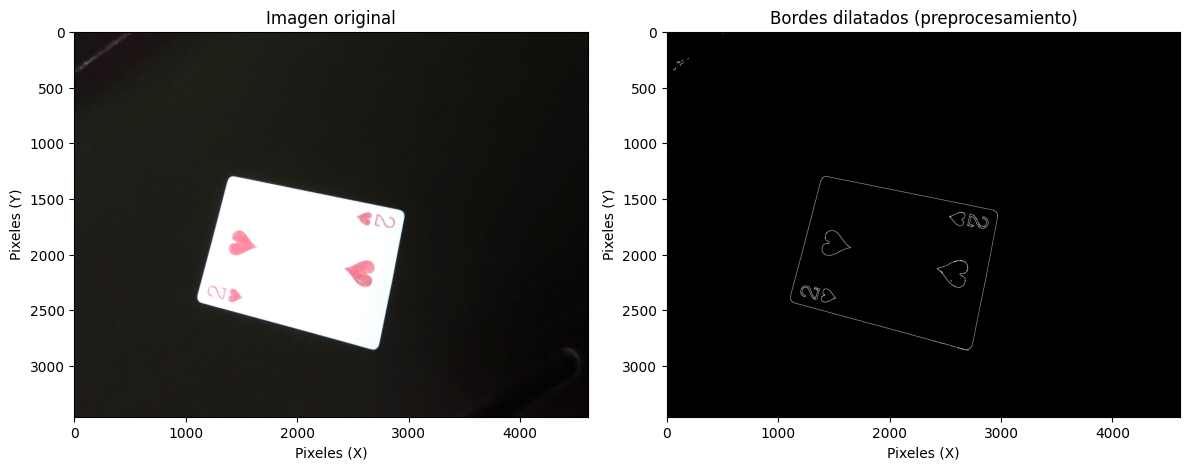

In [17]:
img = cv2.imread("Fotos/Imagenes/2H27.jpg")
edges = preprocess_image(img)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagen original")
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Bordes dilatados (preprocesamiento)")
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 3. Ordenar esquinas del contorno

Cuando detectamos una carta, sus 4 esquinas pueden estar en cualquier orden. Esta función reorganiza esos puntos para que siempre estén en el orden correcto:

1. Top-left
1. Top-right
1. Bottom-right
1. Bottom-left

Esto es esencial para poder aplicar correctamente una transformación de perspectiva más adelante. También incluye una verificación extra por si se detectan coordenadas duplicadas (poco común, pero posible).

In [18]:
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect

## 4. Transformación de perspectiva (warp)
Una vez tenemos los 4 puntos de una carta en el orden correcto, esta función "endereza" la carta como si la viéramos desde arriba.

Pasos que realiza:

1. Calcula las dimensiones reales de la carta usando distancias entre esquinas.
1. Define una nueva cuadrícula rectangular para la carta ya rectificada.
1. Aplica una transformación de perspectiva para que la carta aparezca derecha y recortada.

Resultado: una imagen limpia, alineada y lista para analizar su contenido (número y palo).

In [19]:
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

## 5. Corrección de orientación de la carta
Esta función verifica si la carta se encuentra en la orientación adecuada, es decir, con el número y el símbolo en la esquina superior izquierda.

Para ello, realiza hasta cuatro rotaciones de 90 grados (0°, 90°, 180°, 270°), evaluando en cada paso si la orientación es correcta.

En cada rotación:

- Se extrae una pequeña región de la esquina superior izquierda (ROI).
- La región se convierte a escala de grises, se binariza y se suaviza morfológicamente.
- Se buscan contornos que cumplan con ciertos criterios de área y proporción, los cuales se asumen como posibles número o símbolo.

Si se encuentra al menos un contorno válido, se considera que la carta está en la orientación correcta y se devuelve. En caso contrario, la imagen se rota y se repite el proceso.

Si no se detecta una orientación válida después de cuatro intentos, se devuelve la imagen en su última rotación.

Cuando el parámetro `debug` está activado, se muestran visualizaciones intermedias del proceso.

In [20]:
def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]

    if debug:
        print(f"Dimensiones - Alto: {h}, Ancho: {w}")

    # Si la imagen es más ancha que alta, rotamos 90°
    if w > h:
        if debug:
            print("Rotando la carta 90° en sentido horario")
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)

    return card_img

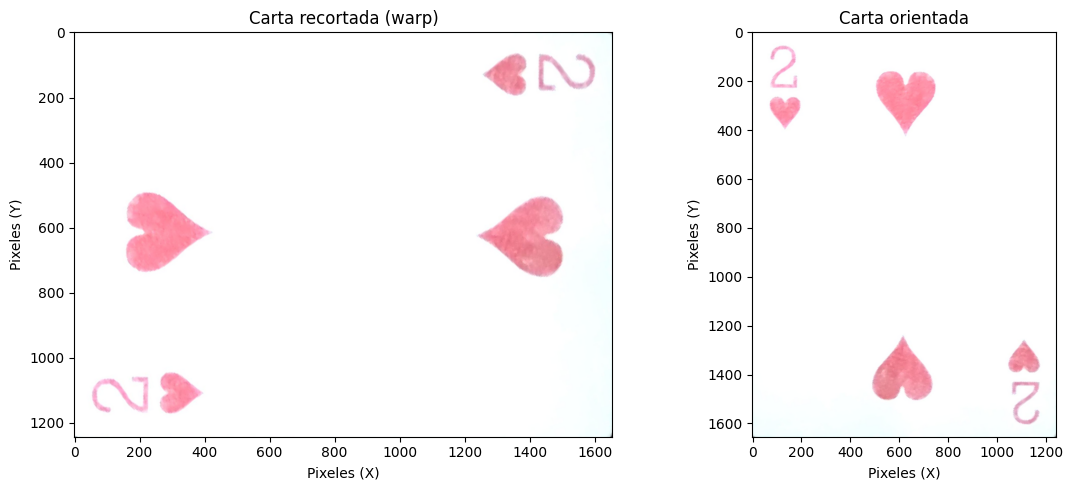

In [21]:

contornos = find_card_contours(preprocess_image(img))

if contornos:
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Carta recortada (warp)")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(oriented, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Carta orientada")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 6. Detección de contornos de cartas

Una vez tenemos la imagen procesada, buscamos contornos que representen cartas.

- Usamos cv2.findContours con RETR_TREE para obtener la jerarquía de contornos (útil para descartar los internos).
- Filtramos contornos externos y con un área mínima para evitar falsos positivos.
- Aplicamos approxPolyDP sobre el convex hull del contorno para obtener una forma más regular.
- Si el contorno tiene 4 lados, lo consideramos una carta. Si no, usamos un método alternativo (minAreaRect) para obtener una caja rectangular aproximada.

Resultado: una lista de contornos que representan cartas detectadas.

In [22]:
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

Aqui tenemos un ejemplo de la función para encontrar los contornos de una carta:

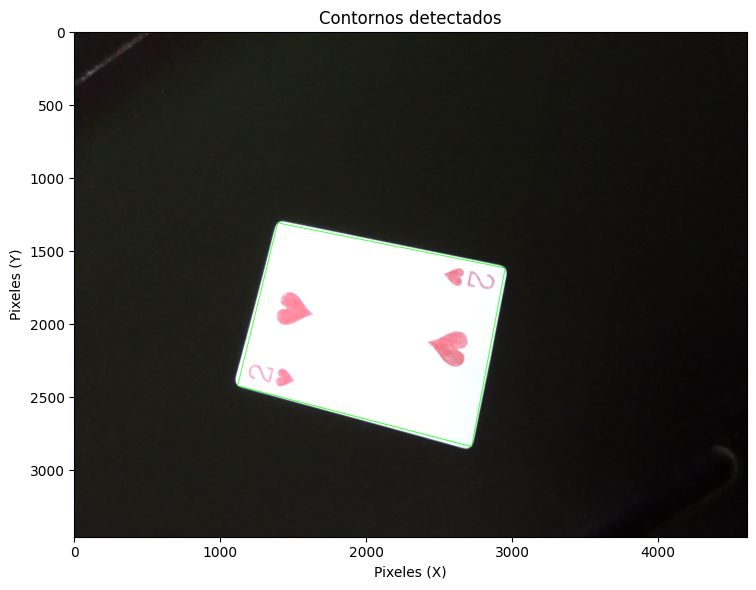

In [23]:
edges = preprocess_image(img)
contornos = find_card_contours(edges)

# Dibujar los contornos detectados sobre una copia de la imagen original
img_contornos = img.copy()
cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 3)

# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Contornos detectados")
plt.xlabel("Pixeles (X)")
plt.ylabel("Pixeles (Y)")
plt.tight_layout()
plt.show()

## 7. Extracción del número y símbolo de la carta

Esta función se encarga de identificar y extraer la región donde se encuentra el número (rango) y el símbolo (palo) de la carta, generalmente ubicados en la esquina superior izquierda.

Pasos que realiza:

1. Se recorta una región de interés (ROI) desde la esquina superior izquierda de la carta. Esta región cubre aproximadamente el 25% de la altura y el 18% del ancho de la imagen. Estos valores pueden ajustarse si es necesario.
1. Se convierte la región a escala de grises, se mejora su contraste y se binariza usando un umbral adaptativo.
1. Se aplica suavizado morfológico para limpiar la imagen.
1. Se detectan contornos externos y se seleccionan los dos más grandes, asumiendo que corresponden al número y al palo.
1. Se ordenan los contornos de arriba hacia abajo (por coordenada vertical), y cada uno se recorta y redimensiona:
1. El primer contorno se considera el número.
1. El segundo contorno se considera el palo.
1. Si se encuentra exactamente un número y un palo, ambos se devuelven como imágenes separadas. En caso contrario, se devuelve `None`.
1. Si `debug=True`, se muestran visualizaciones del ROI, la binarización y las regiones recortadas del número y símbolo para facilitar la depuración.

In [24]:
def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.15)]  # zona donde aparece número y palo

    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("ROI (Esquina superior izquierda)")
        plt.axis("off")
        plt.show()

    # 🔎 Preprocesado y binarización
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)

    # 📏 Buscar contornos externos
    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 🧹 FILTRAR: ignorar contornos muy pequeños (ruido)
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 80]

    if debug:
        print(f"Contornos totales: {len(contours)} | Filtrados: {len(filtered_contours)}")
        drawn = roi.copy()
        cv2.drawContours(drawn, filtered_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Contornos Filtrados (Verde)")
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(bin_roi, cmap="gray")
        plt.title("Binarización Final")
        plt.axis("off")
        plt.show()

    # 🧠 Elegimos los 2 contornos más grandes
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:2]
    filtered_contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[1])  # orden por Y

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(filtered_contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                plt.imshow(cv2.cvtColor(joined, cv2.COLOR_BGR2RGB))
                plt.title("Número y Palo")
                plt.show()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]

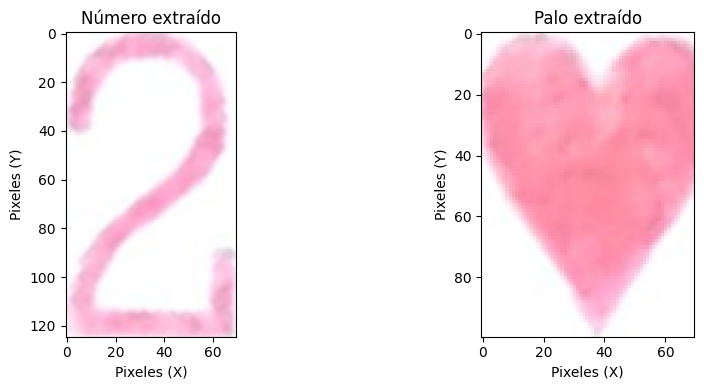

In [25]:
number_img, suit_img = extract_number_suit_region(oriented)

if number_img is not None and suit_img is not None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(cv2.cvtColor(number_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Número extraído")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(suit_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Palo extraído")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 8. Binarización de una región
Esta función convierte una región (en escala de grises o en color) en una imagen binaria, donde los elementos relevantes (como números o símbolos) quedan en blanco sobre fondo negro.

Pasos que realiza:

1. Asegura que los parámetros `block_size` y blur_ksize sean impares, ya que así lo requiere OpenCV.
1. Convierte la región a escala de grises si aún no lo está.
1. Aplica CLAHE (opcional, pero activado por defecto) para mejorar el contraste local, útil cuando la imagen tiene iluminación desigual.
1. Suaviza la imagen con un desenfoque gaussiano para reducir el ruido.
1. Aplica un umbral adaptativo con inversión (`THRESH_BINARY_INV`), lo que resalta las zonas oscuras sobre fondo claro.

Este proceso mejora la segmentación de caracteres y símbolos para su posterior análisis.

In [26]:
def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
    
    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

## 9. Suavizado morfológico
Esta función aplica operaciones morfológicas sobre una imagen binaria para mejorar su limpieza y legibilidad.

Pasos que realiza:

1. Cierre morfológico (`MORPH_CLOSE`): rellena pequeños huecos negros dentro de áreas blancas.
1. Apertura morfológica (`MORPH_OPEN`): elimina puntos blancos aislados que puedan considerarse ruido.

El resultado es una imagen binaria más limpia, ideal para una detección de contornos más precisa. Se utiliza comúnmente después de la binarización para mejorar la calidad de las regiones a analizar.

In [27]:
def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

## 10. Utilidades para preparar imágenes y plantillas

Estas funciones se encargan de normalizar, binarizar o redimensionar imágenes para que puedan ser comparadas correctamente con las plantillas.

- `resize_for_template(img, template_shape)`: redimensiona una imagen para que tenga el mismo tamaño que una plantilla.
- `normalize_for_template(img)`: aplica desenfoque y normalización de intensidad, útil en ciertos casos para estandarizar imágenes antes de comparar.
- `binarize_template(template)`: convierte una plantilla en imagen binaria mediante umbralado fijo. Asume que los elementos están sobre fondo blanco y no se invierte el resultado.

In [28]:
def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

## 11. Verificación de contenido en una región

La función region_has_rank_or_suit se utiliza para comprobar si una región (por ejemplo, una esquina de la carta) contiene información relevante como un número o un símbolo.

Para ello:

- Convierte la región a escala de grises.
- Calcula la desviación estándar de la intensidad (para medir variación).
- Cuenta la cantidad de píxeles "oscuros".

Devuelve `True` si la variación y la cantidad de píxeles oscuros superan ciertos umbrales, lo que indica que probablemente hay contenido gráfico en la región.

In [29]:
def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels

## 12. Carga de plantillas de números y palos

La función `load_templates` carga todas las plantillas de números y símbolos desde la carpeta `Fotos/Plantillas`.

- Busca todos los archivos `.jpg` cuyo nombre comience con el nombre del número o palo (`Ace`, `Two`, `Clubs`, etc.).
- Cada plantilla se carga en escala de grises y se almacena en un diccionario con su nombre como clave.

Devuelve dos diccionarios:

- `number_templates`: para comparar números.
- `suit_templates`: para comparar palos.

In [30]:
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates

## 13. Comparación de una región con plantillas

La función `match_template` compara una región de una carta (como el número o el símbolo) con un conjunto de plantillas precargadas.

Pasos que realiza:

1. Binariza y suaviza la región objetivo.
1. Para cada plantilla del conjunto:
- Se binariza.
- Se redimensiona la región objetivo al tamaño de la plantilla.
- Se calcula una correlación normalizada (`cv2.matchTemplate`) para comparar similitud.
3. Se selecciona la plantilla con mayor puntuación como resultado.

Opcionalmente, se pueden mostrar las imágenes comparadas si `debug=True`.

In [31]:
def match_template(region, templates, debug=False):
    # binary = binarize_region(region)

    bin_roi = binarize_region(region, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    binary = morphological_smoothing(bin_roi)
    
    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            templ_bin = binarize_template(template)
            # templ_bin = normalize_for_template(templ_bin)

            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            if debug:
                # Mostrar REGION (izquierda)
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(binary, cmap='gray')
                plt.title("Recorte de la carta")
                plt.axis("off")

                # Mostrar TEMPLATE (derecha)
                plt.subplot(1, 2, 2)
                plt.imshow(templ_bin, cmap='gray')  # ya es binarizada
                plt.title(f"Template: {name}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()


            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if debug:
                print(f"{name}: score = {max_val:.4f}")

            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name

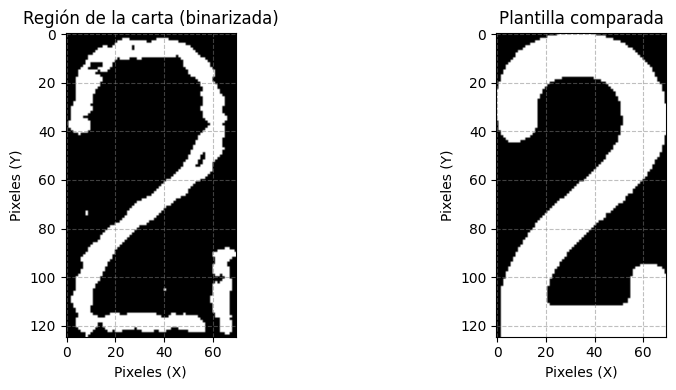

In [32]:
number_templates, suit_templates = load_templates()
templ_bin = binarize_template(number_templates['Two'][0])
resized = cv2.resize(binarize_region(number_img), (templ_bin.shape[1], templ_bin.shape[0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(resized, cmap='gray')
axs[0].set_title("Región de la carta (binarizada)")
axs[0].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(templ_bin, cmap='gray')
axs[1].set_title("Plantilla comparada")
axs[1].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 14. Validación de proporción de la carta

La función `is_valid_card_proportion` verifica si la carta rectificada tiene una proporción (alto/ancho) razonable.

Esto sirve para descartar deformaciones por errores en el proceso de recorte o warping.

La proporción esperada es aproximadamente 1:1. Se permite un margen (`jump_ratio`) para evitar rechazar cartas ligeramente distorsionadas.

Devuelve `True` si la proporción está dentro del rango aceptable.

In [33]:
def is_valid_card_proportion(warped_img, jump_ratio=0.7, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

## 15. Ejecución principal del sistema (`main`)

Esta función coordina todo el flujo del reconocimiento:

1. Carga la imagen desde disco.
1. La preprocesa para detectar bordes.
1. Encuentra los contornos de las cartas.
1. Para cada carta detectada:
- Se corrige la perspectiva (warp).
- Se rota para asegurar la orientación correcta.
- Se valida la proporción.
- Se extraen las regiones del número y el símbolo.
- Se comparan estas regiones con plantillas para identificar la carta.

Permite activar modo `debug` para visualizar cada paso.

Devuelve el número y el palo detectados de la primera carta válida encontrada en la imagen.

In [40]:
def main(path, debug=False, draw_predictions=True, show_result=True):
    image = cv2.imread(path)
    original = image.copy()

    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    card_contours = find_card_contours(edges)
     # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()

    if debug:
        print(f"🟢 Cartas detectadas: {len(card_contours)}")

    number_templates, suit_templates = load_templates()
    detected_cards = []

    for i, contour in enumerate(card_contours):
        warped = warp_card(image, contour)
        if warped is None:
            if debug:
                print(f"❌ Contorno {i} no pudo ser transformado.")
            continue

        warped = correct_card_orientation(warped, debug)
        if warped is None or not is_valid_card_proportion(warped, debug=debug):
            if debug:
                print(f"⚠️ Contorno {i} descartado por proporción.")
            continue

        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        number_region, suit_region = extract_number_suit_region(warped, debug=debug)
        if debug:
            print("Template mathing:")
        if number_region is not None and suit_region is not None:
            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)
            detected_cards.append((contour, number, suit))

            if debug:
                print(f"🃏 Carta {i + 1}: {number} de {suit}")
        else:
            if debug:
                print(f"❌ Carta {i + 1}: no se pudo extraer número y palo.")

    # 🔤 Dibujar los resultados sobre la imagen original
    if draw_predictions:
        for i, (contour, number, suit) in enumerate(detected_cards):
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = contour[0][0]

            label = f"{number} of {suit}"
            # Obtener tamaño del texto (retorna tamaño y línea base)
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)

            # Ajustar el punto de inicio para centrar horizontalmente
            text_x = cx - text_width // 2
            text_y = cy + text_height // 2  # Puedes ajustar el Y si quieres moverlo arriba/abajo

            # Dibujar texto centrado
            cv2.putText(original, label, (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
            cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

    # Mostrar la imagen final
    if show_result:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.axis("off")
        plt.show()

    # Devolver resultados en forma de lista
    return [(number, suit) for _, number, suit in detected_cards]


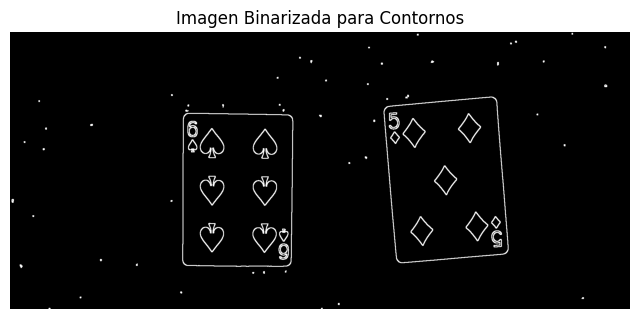

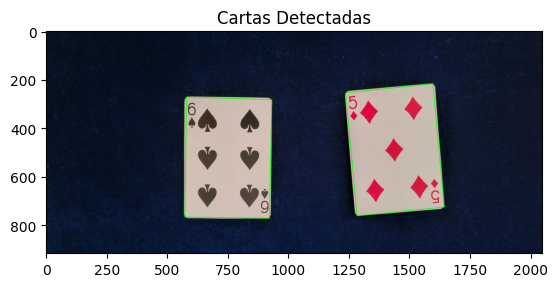

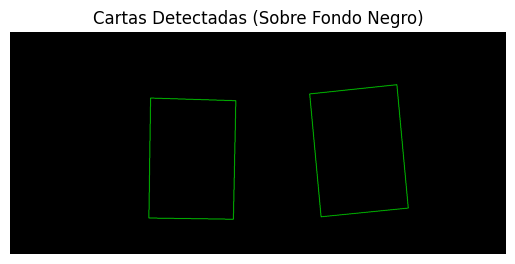

🟢 Cartas detectadas: 2
Dimensiones - Alto: 495, Ancho: 352
[DEBUG] Dimensiones carta: 352x495 | Ratio: 1.41 | 0.30000000000000004 <= 1.41 <= 1.7
	Resultado:True


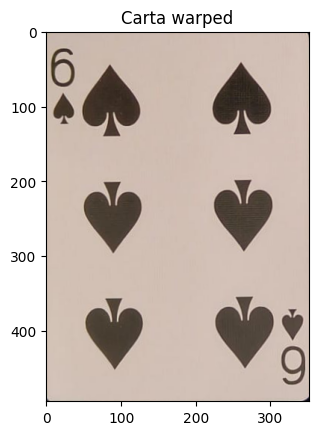

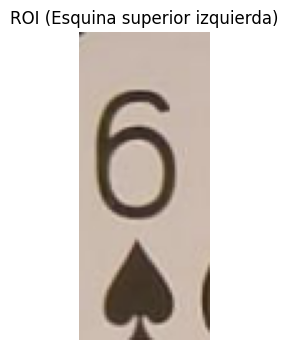

Contornos totales: 10 | Filtrados: 2


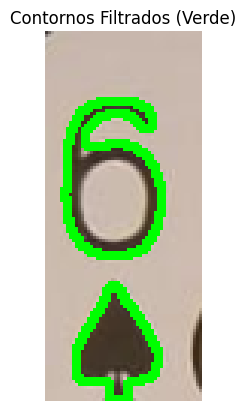

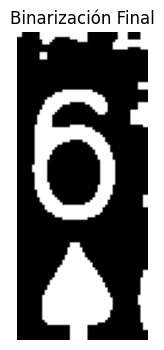

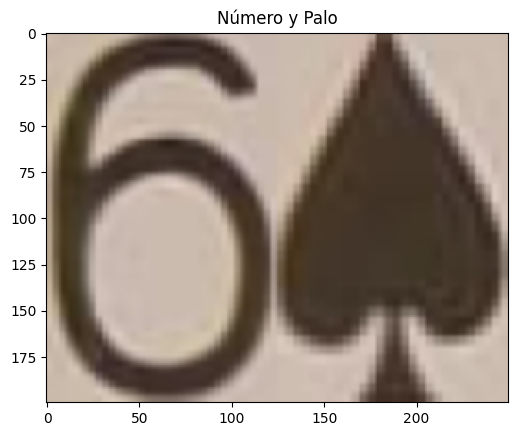

Template mathing:


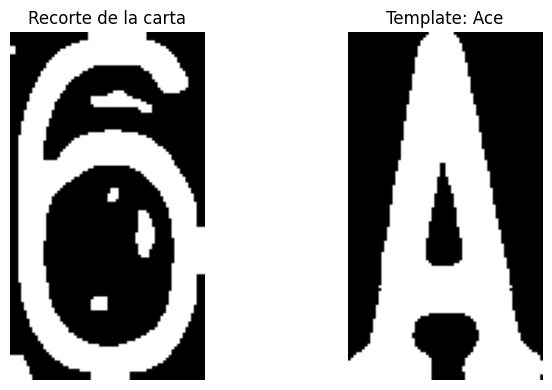

Ace: score = -0.1027


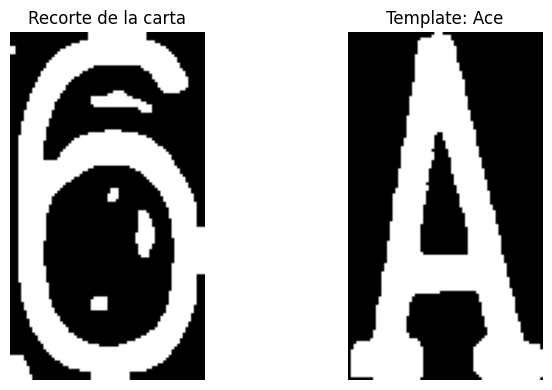

Ace: score = -0.0867


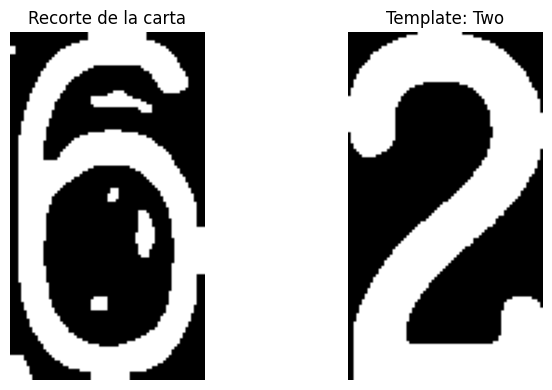

Two: score = 0.0755


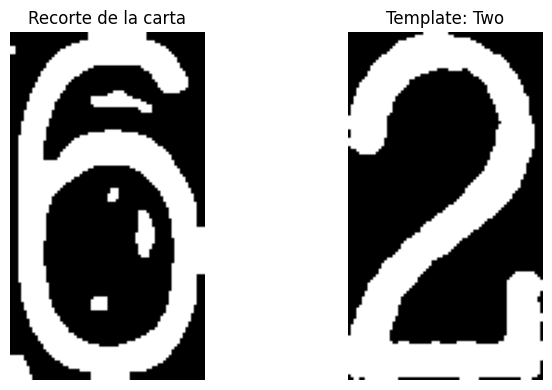

Two: score = 0.1708


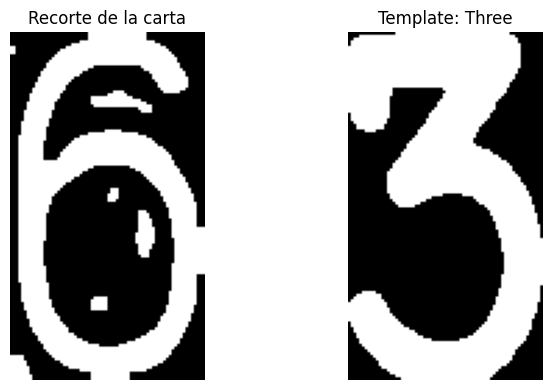

Three: score = 0.3799


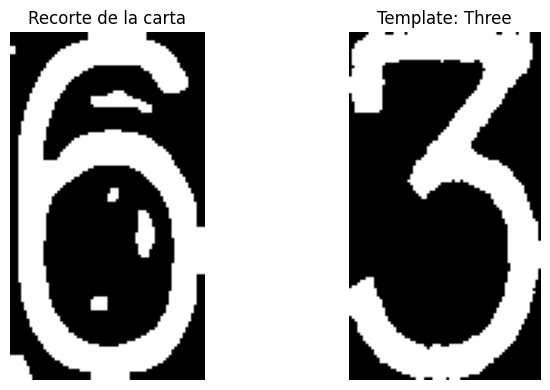

Three: score = 0.3827


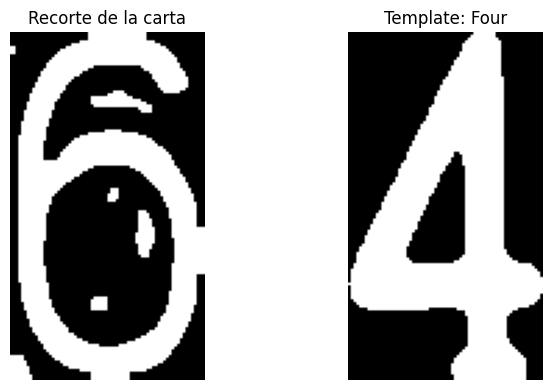

Four: score = 0.0137


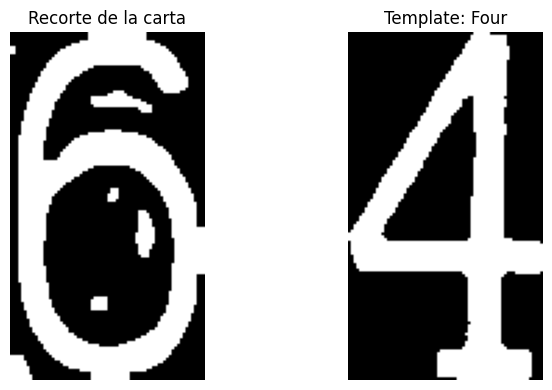

Four: score = 0.0809


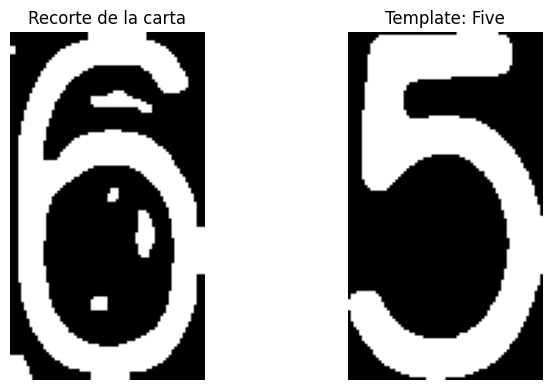

Five: score = 0.5065


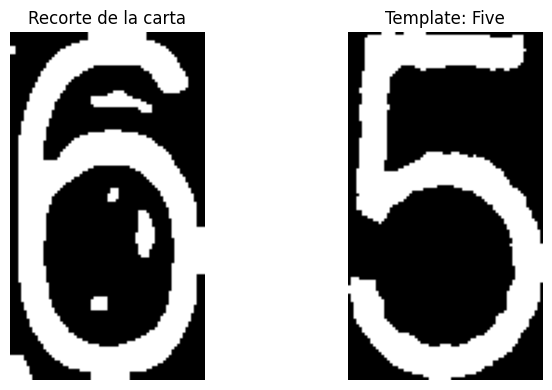

Five: score = 0.5145


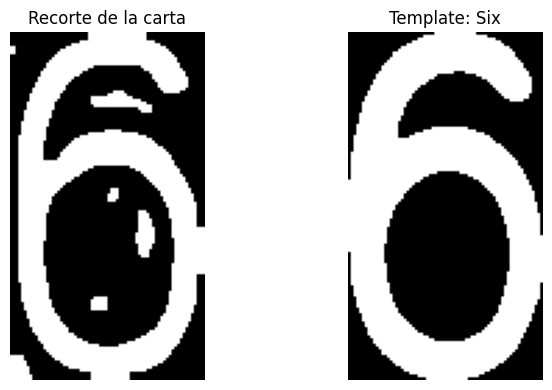

Six: score = 0.7110


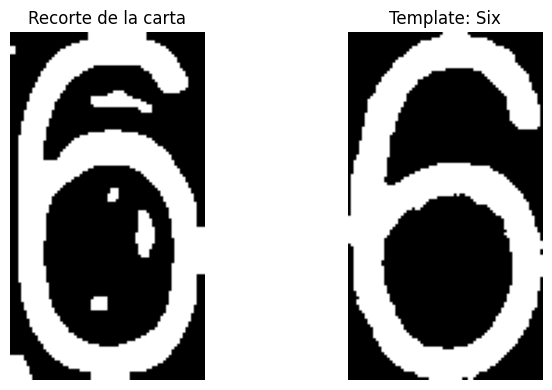

Six: score = 0.5418


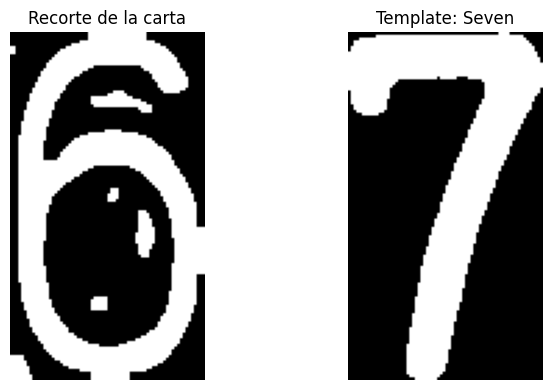

Seven: score = -0.0518


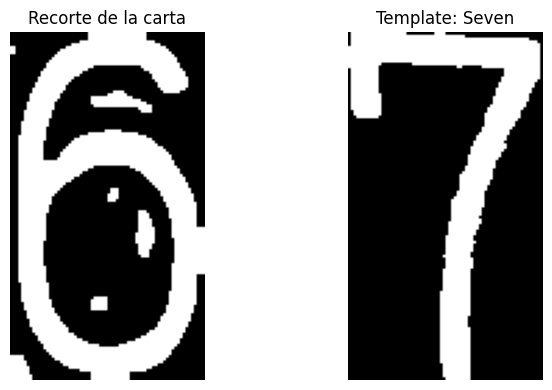

Seven: score = -0.0342


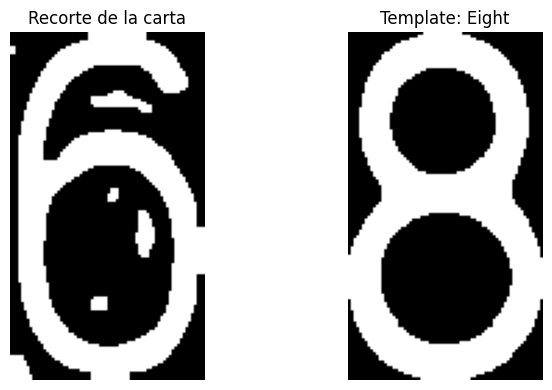

Eight: score = 0.4341


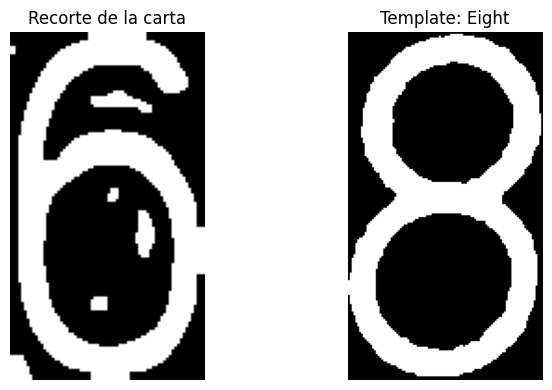

Eight: score = 0.4085


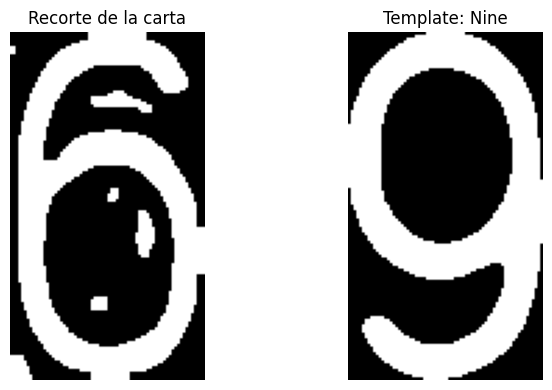

Nine: score = 0.3455


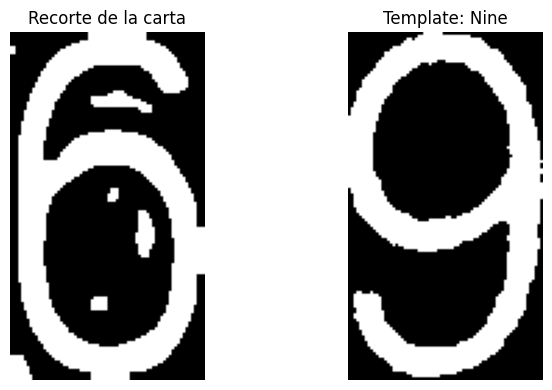

Nine: score = 0.3179


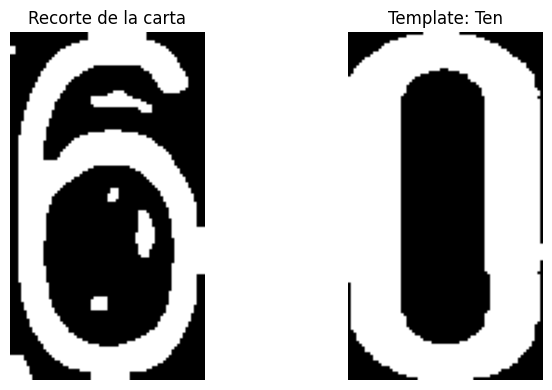

Ten: score = 0.3841


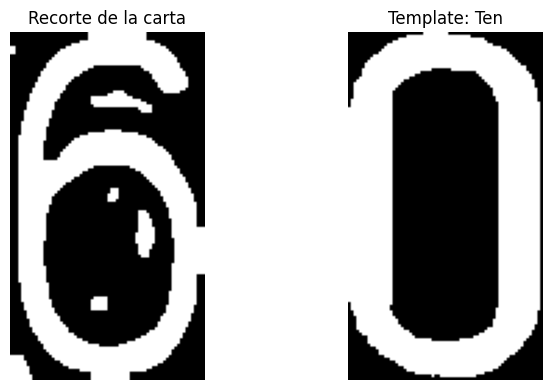

Ten: score = 0.4579


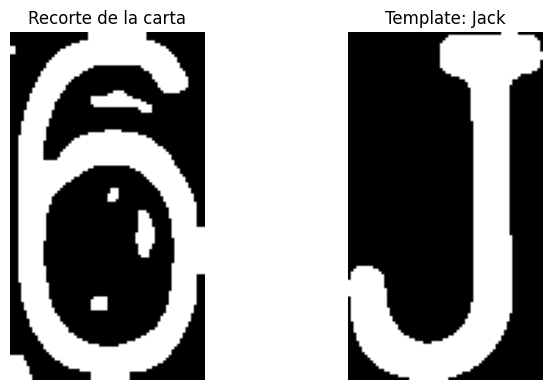

Jack: score = 0.1316


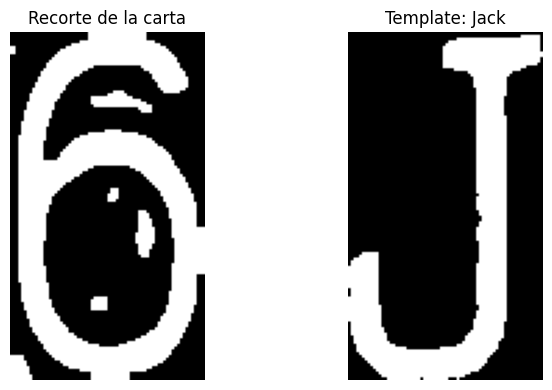

Jack: score = 0.1159


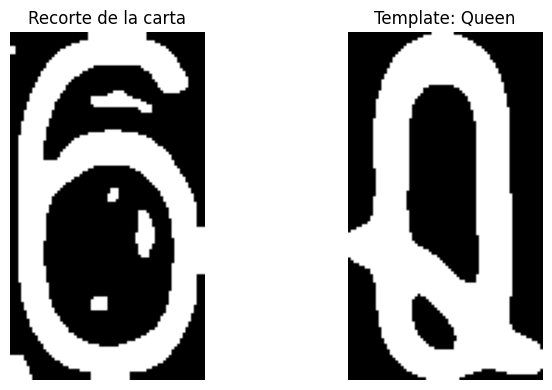

Queen: score = 0.1210


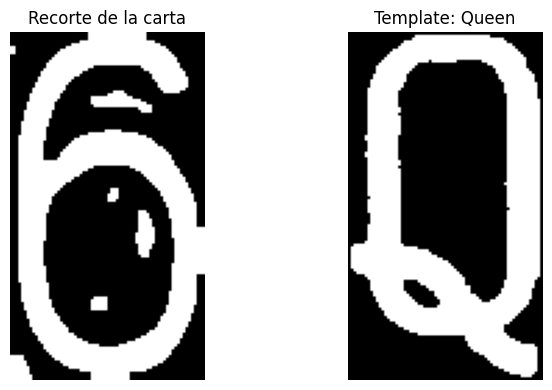

Queen: score = 0.1649


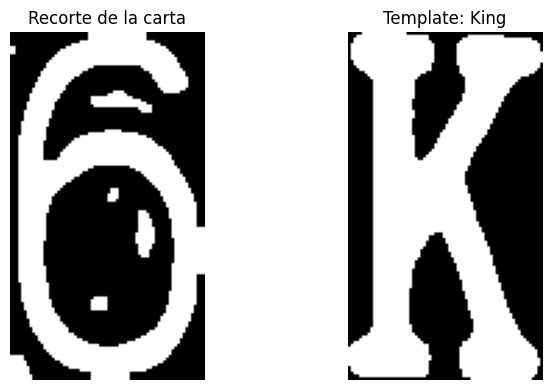

King: score = 0.0208


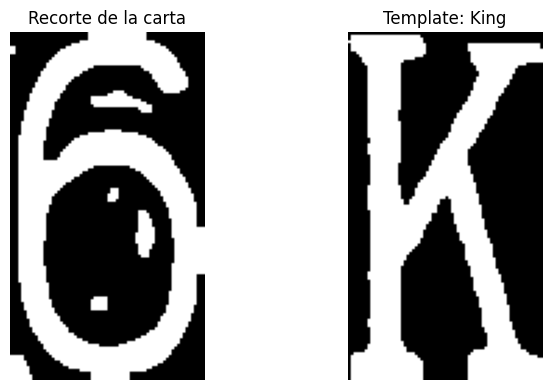

King: score = 0.0565


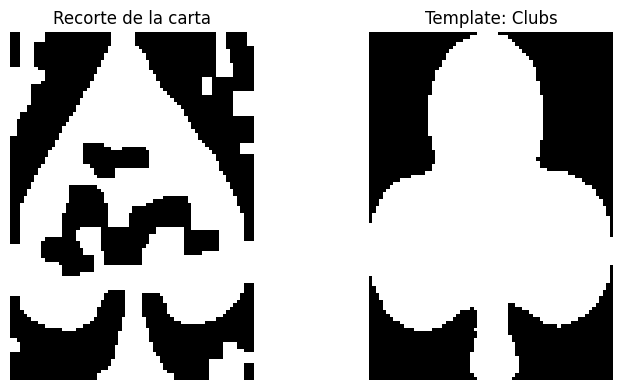

Clubs: score = 0.4982


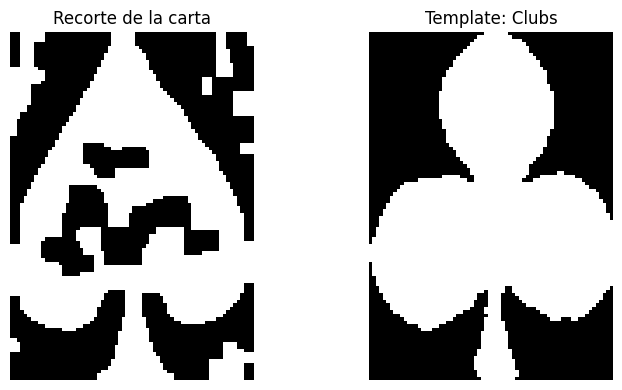

Clubs: score = 0.4686


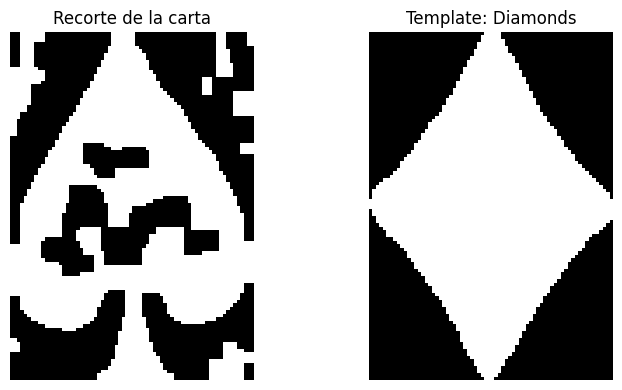

Diamonds: score = 0.3412


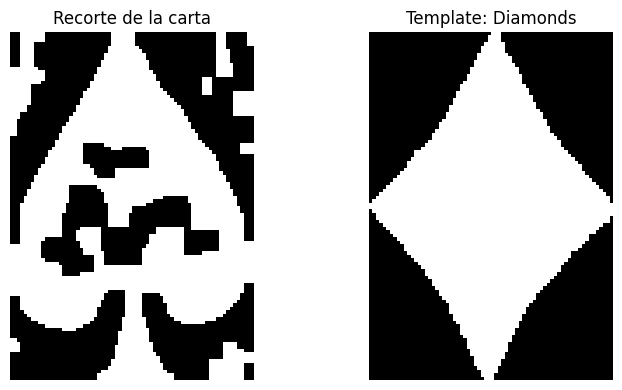

Diamonds: score = 0.3202


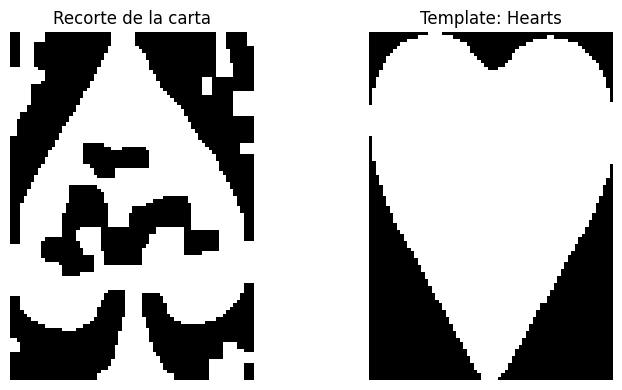

Hearts: score = 0.0579


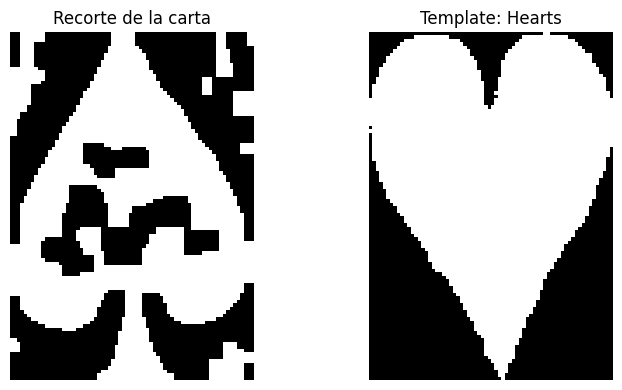

Hearts: score = 0.0232


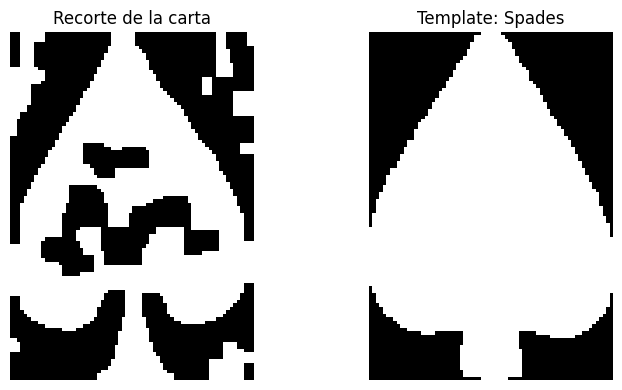

Spades: score = 0.5118


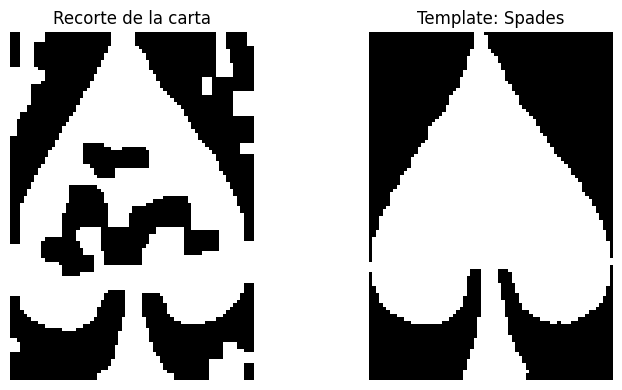

Spades: score = 0.5399
🃏 Carta 1: Six de Spades
Dimensiones - Alto: 511, Ancho: 362
[DEBUG] Dimensiones carta: 362x511 | Ratio: 1.41 | 0.30000000000000004 <= 1.41 <= 1.7
	Resultado:True


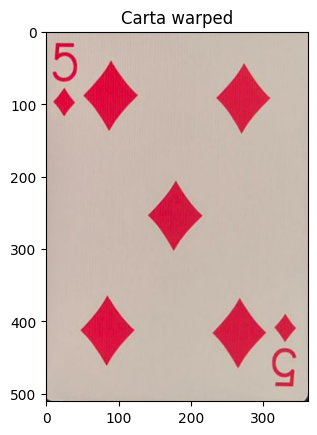

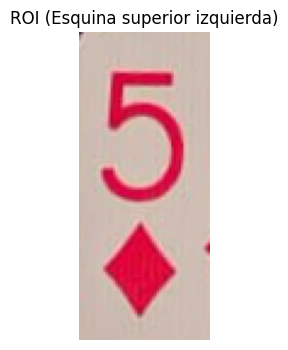

Contornos totales: 13 | Filtrados: 2


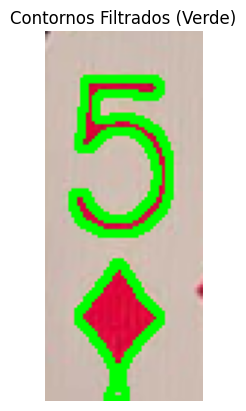

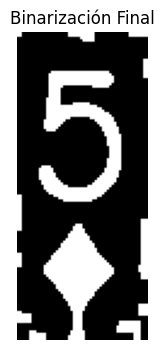

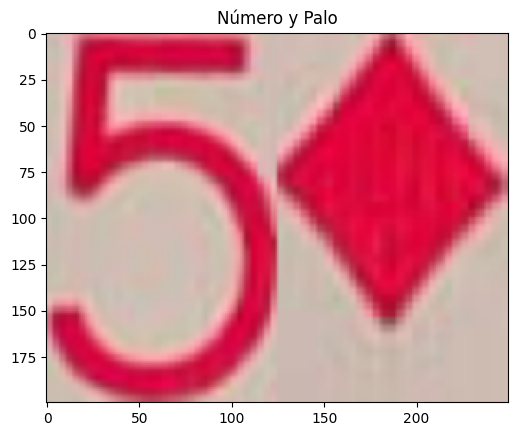

Template mathing:


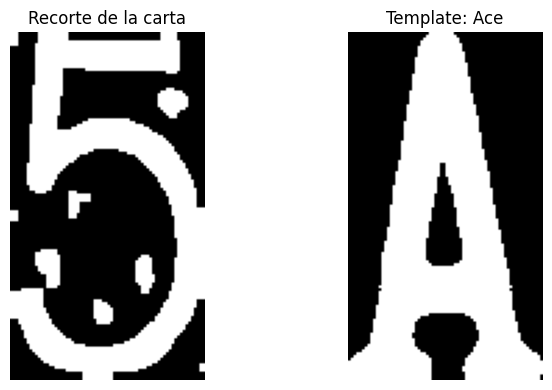

Ace: score = -0.1173


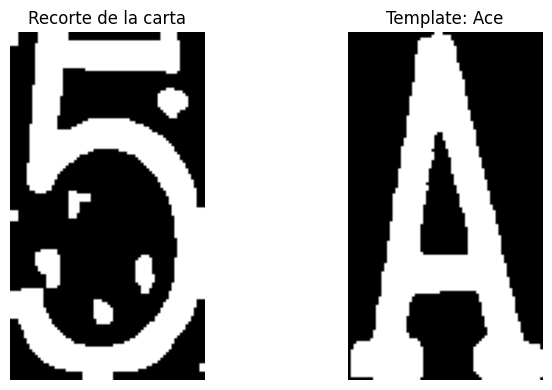

Ace: score = -0.0820


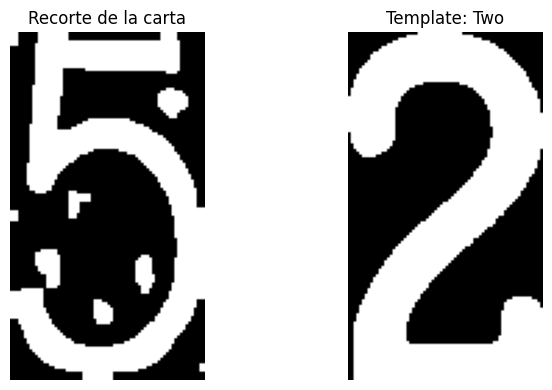

Two: score = 0.1143


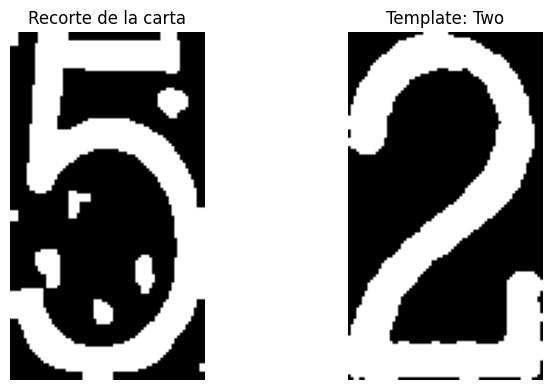

Two: score = 0.1996


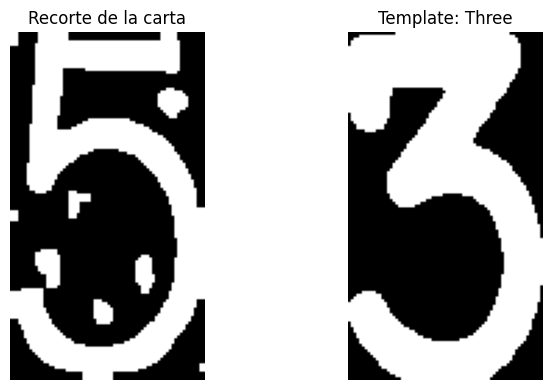

Three: score = 0.3857


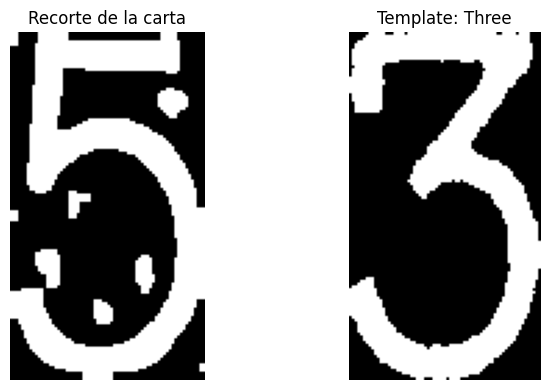

Three: score = 0.4156


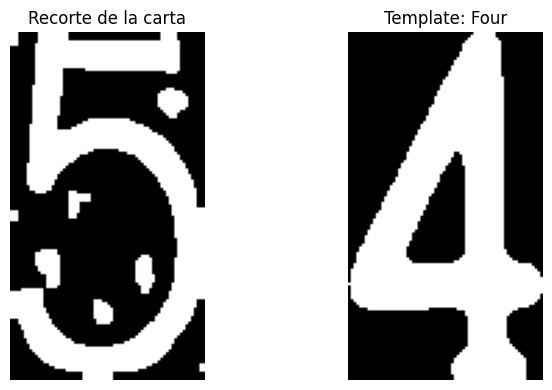

Four: score = -0.0684


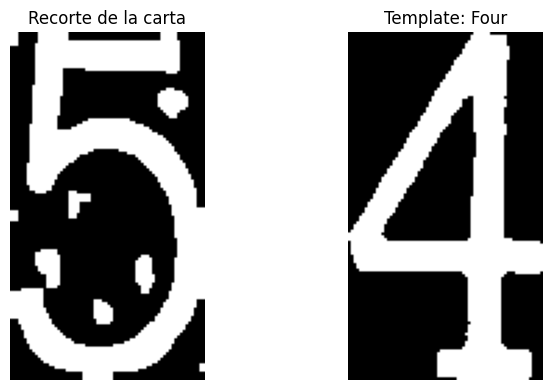

Four: score = -0.0324


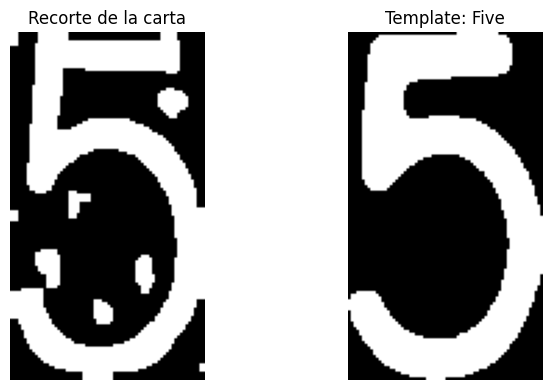

Five: score = 0.7074


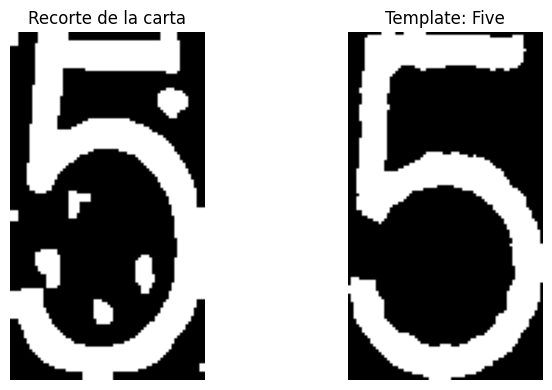

Five: score = 0.4393


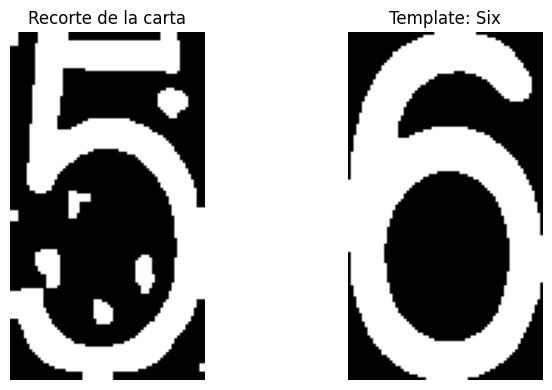

Six: score = 0.4904


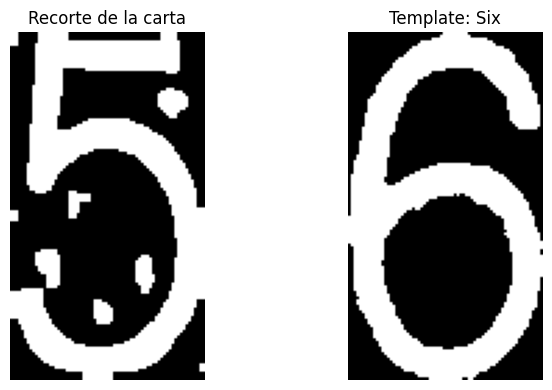

Six: score = 0.3275


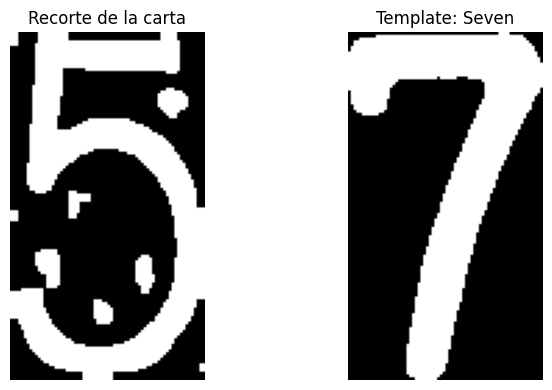

Seven: score = 0.0113


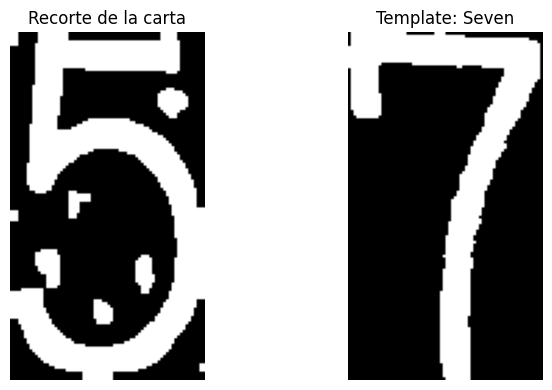

Seven: score = 0.0457


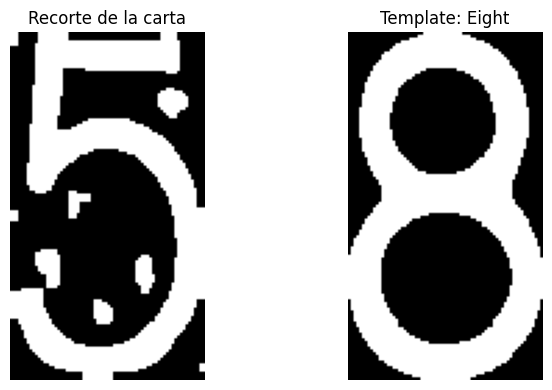

Eight: score = 0.3697


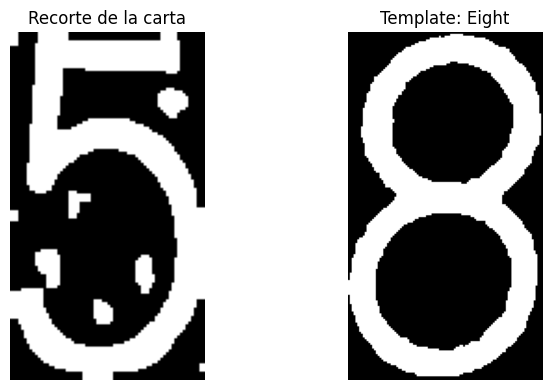

Eight: score = 0.3498


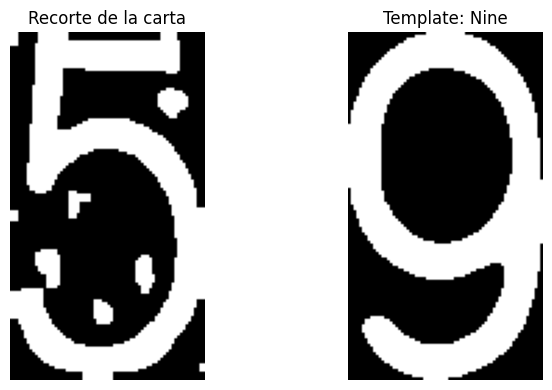

Nine: score = 0.2914


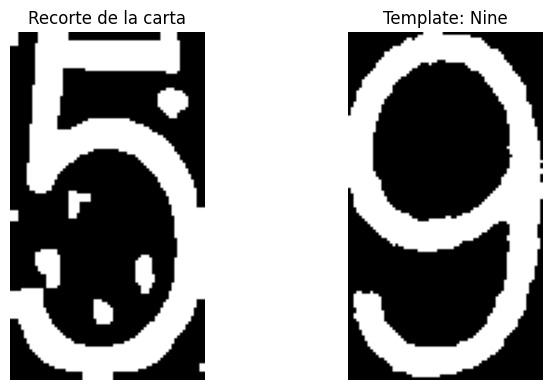

Nine: score = 0.2917


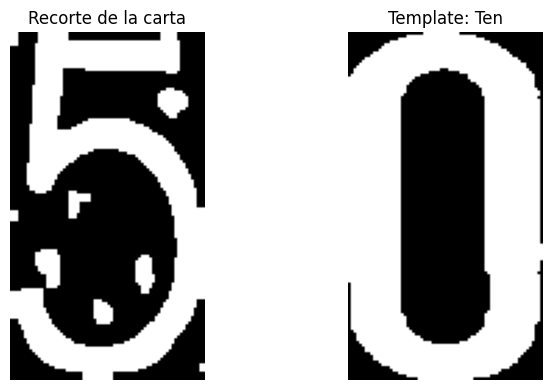

Ten: score = 0.3560


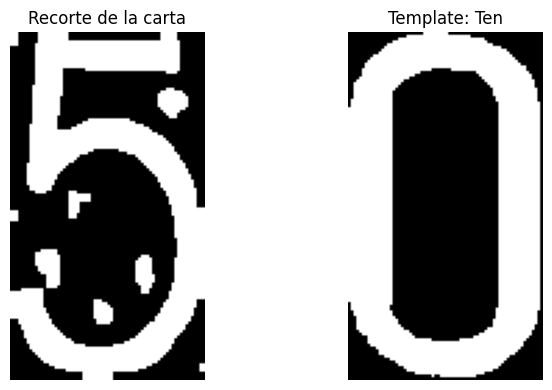

Ten: score = 0.3922


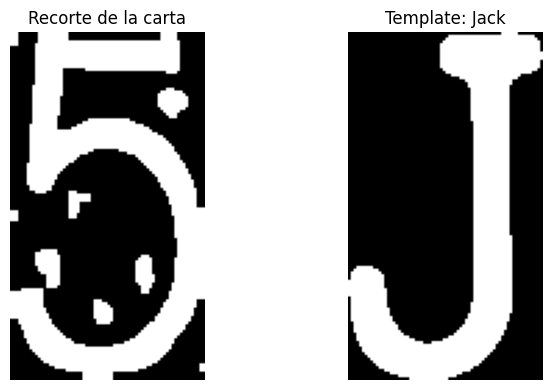

Jack: score = 0.1771


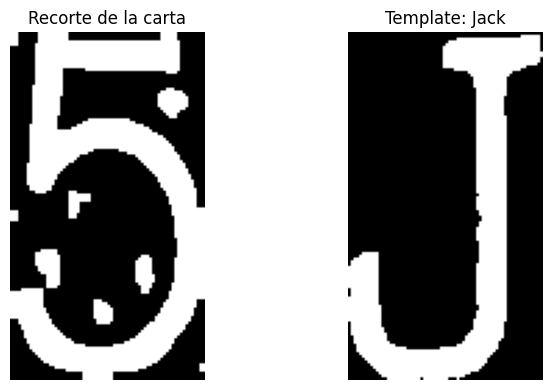

Jack: score = 0.1837


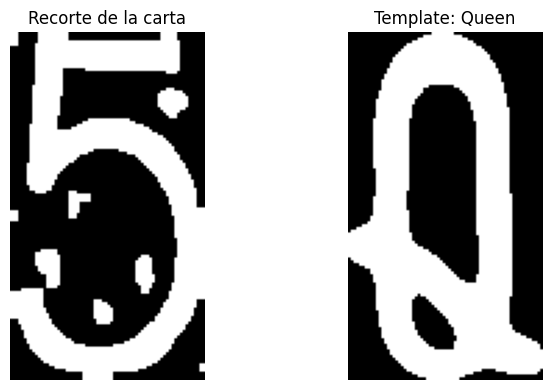

Queen: score = 0.0668


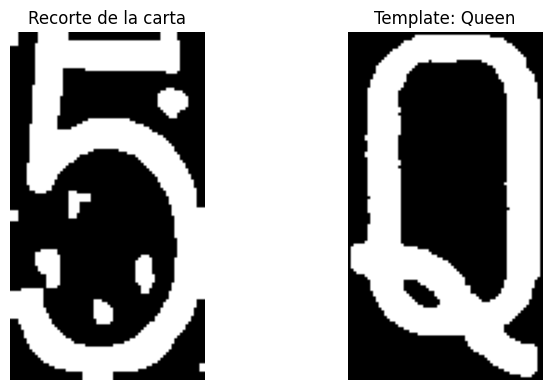

Queen: score = 0.1704


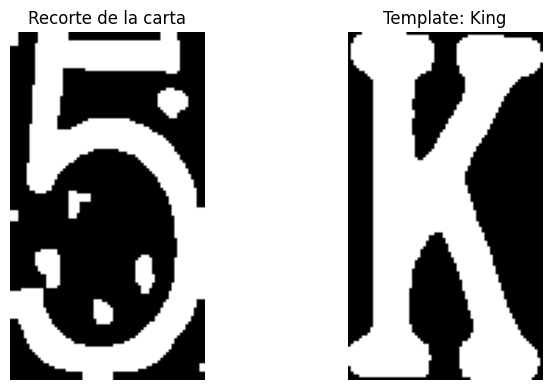

King: score = 0.0830


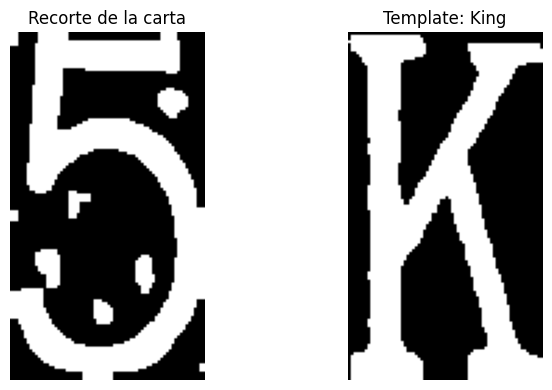

King: score = 0.1077


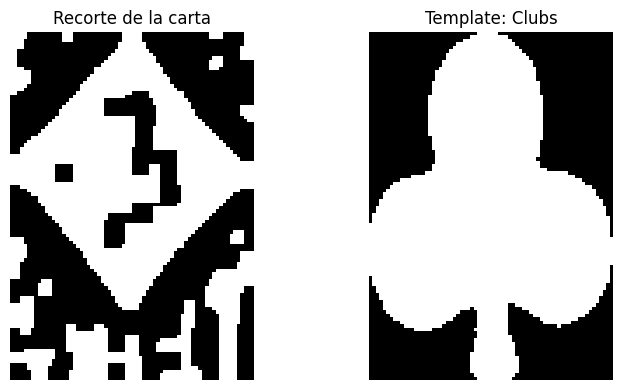

Clubs: score = 0.1598


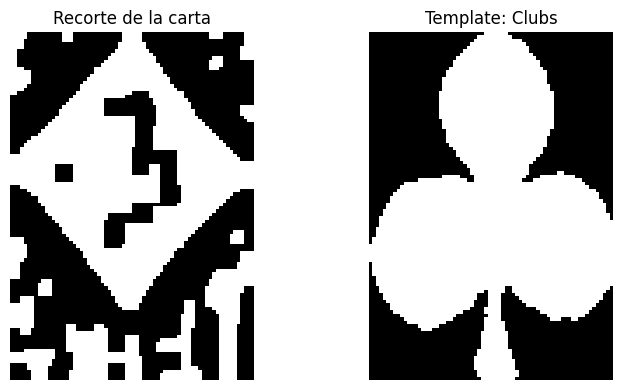

Clubs: score = 0.1527


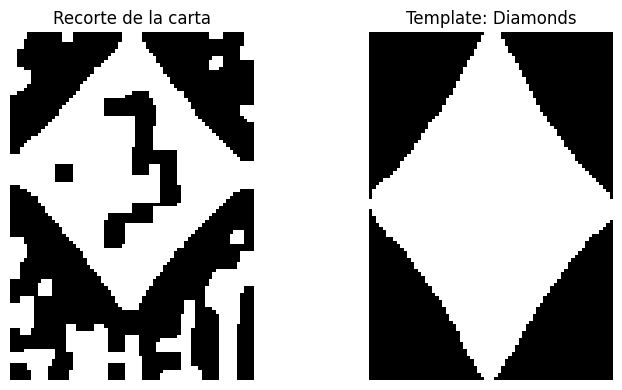

Diamonds: score = 0.2497


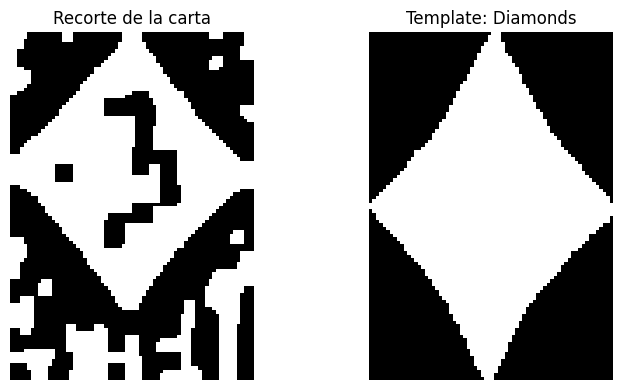

Diamonds: score = 0.2439


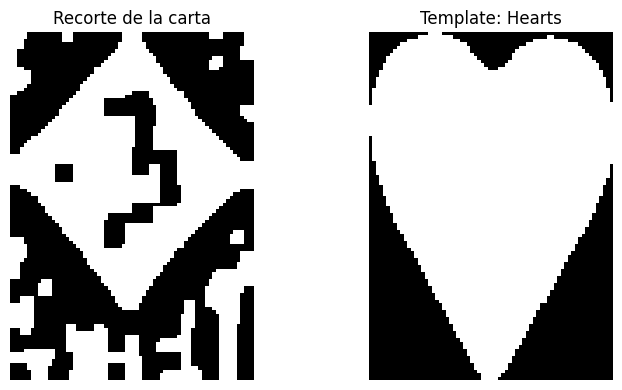

Hearts: score = 0.1079


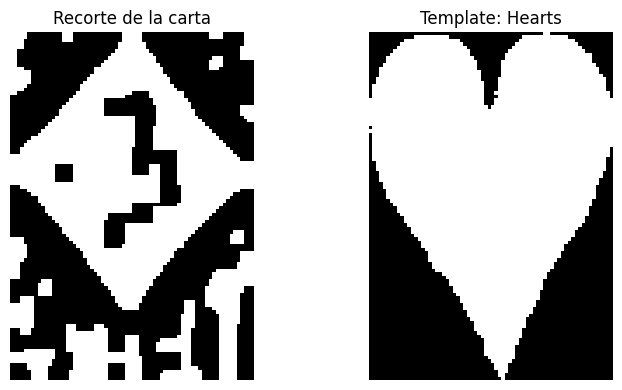

Hearts: score = 0.1556


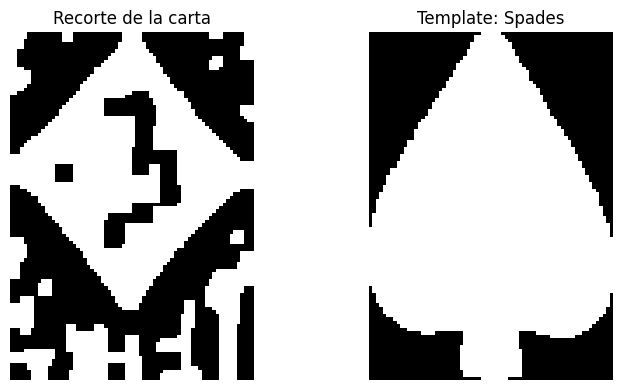

Spades: score = 0.2389


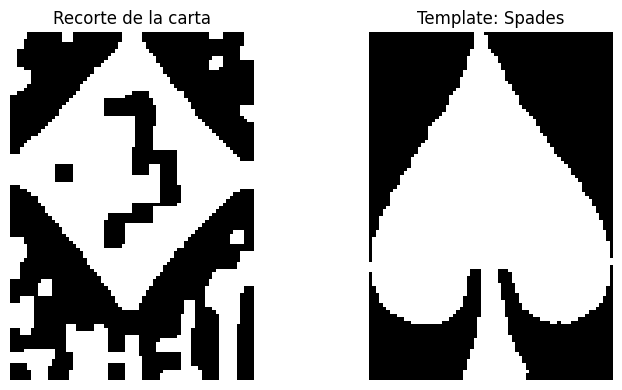

Spades: score = 0.1597
🃏 Carta 2: Five de Diamonds


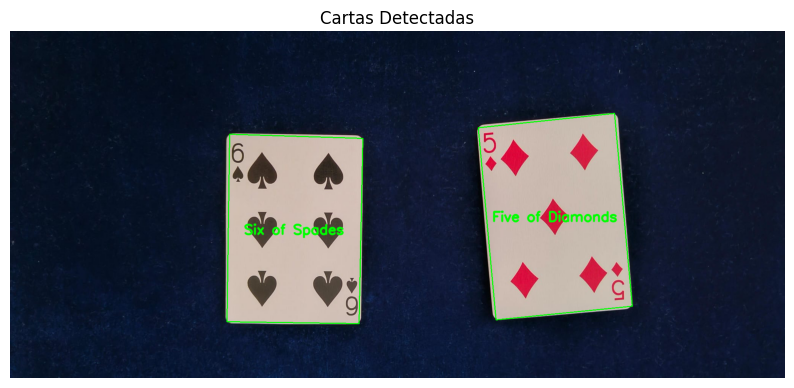

[('Six', 'Spades'), ('Five', 'Diamonds')]
Carta 1: Six de Spades
Carta 2: Five de Diamonds


In [35]:
results = main("Fotos/fotos_multiples/5D6S2.jpg", debug=True)
print(results)
for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

## Todas la funciones declaradas:

Se debería de quitar una vez que se compruebe de que arriba están todas.

También viene incluido el antiguo `main` que solo puede detectar una carta a la vez.

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect
"""
def sort_corners(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect
"""
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

"""
def find_card_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    proper = sorted(contours, key=cv2.contourArea, reverse=True)
    card_contours = []

    for cnt in proper:
        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        perimeter = cv2.arcLength(cnt, closed=True)
        approx = cv2.approxPolyDP(cnt, 0.01 * perimeter, closed=True)  # Más permisivo

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # 🩹 Fallback con minAreaRect
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours
"""
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.15)]  # zona donde aparece número y palo

    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("ROI (Esquina superior izquierda)")
        plt.axis("off")
        plt.show()

    # 🔎 Preprocesado y binarización
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)

    # 📏 Buscar contornos externos
    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 🧹 FILTRAR: ignorar contornos muy pequeños (ruido)
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 80]

    if debug:
        print(f"Contornos totales: {len(contours)} | Filtrados: {len(filtered_contours)}")
        drawn = roi.copy()
        cv2.drawContours(drawn, filtered_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Contornos Filtrados (Verde)")
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(bin_roi, cmap="gray")
        plt.title("Binarización Final")
        plt.axis("off")
        plt.show()

    # 🧠 Elegimos los 2 contornos más grandes
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:2]
    filtered_contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[1])  # orden por Y

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(filtered_contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                plt.imshow(cv2.cvtColor(joined, cv2.COLOR_BGR2RGB))
                plt.title("Número y Palo")
                plt.show()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]


"""
def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.12)]  # Ajustable si hace falta más ancho o alto
    
    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Crop Esquina Superior Izquierda (ROI)")
        plt.axis("off")
        plt.show()
    
    # 🔎 Detectar contornos
    if debug:
        print("Detectar los contornos")
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    bin_roi = binarize_region(gray_roi, block_size=30, C=0, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    # _, bin_roi = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if debug:
        drawn = roi.copy()
        cv2.drawContours(drawn, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()
    
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # orden vertical
    
    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(bin_roi)
        plt.title("Bin")
        plt.axis("off")
        plt.show()

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                plt.figure(figsize=(4, 4))
                plt.imshow(joined)
                plt.title("Debug crop")
                plt.axis("off")
                plt.show()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]
"""

def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

"""
def binarize_region(region):
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region
    blur = cv2.GaussianBlur(gray, (7, 7), 0)  # Suavizar ruido
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=11, C=4
    )
    return binary
"""

def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
    
    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

"""
def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]
    roi_h, roi_w = int(h * 0.2), int(w * 0.15)

    for i in range(4):
        roi = card_img[0:roi_h, 0:roi_w]
        
        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
            
        if roi is None or roi.size == 0:
            print("⚠️ ROI vacío. No se puede convertir a escala de grises.")
            return None  # o manejarlo como prefieras
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (5, 5), 0)
        bin_roi = binarize_region(gray, block_size=10, C=2, blur_ksize=5, use_clahe=True)
        bin_roi = morphological_smoothing(bin_roi)
        
        if debug:
            bin_roi = cv2.adaptiveThreshold(
                blur, 255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                blockSize=11, C=3
            )

        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(bin_roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
        contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos pequeños (posibles número y palo)
        filtered = []
        for cnt in contours:
            x, y, wc, hc = cv2.boundingRect(cnt)
            area = wc * hc
            ratio = wc / float(hc) if hc != 0 else 0
            if (300 < area < 15000) and (0.3 < ratio < 1.5):  # Rango para número o símbolo, ajustar si necesario                
                filtered.append((x, y, wc, hc))

        # Ordenar por coordenada Y
        filtered = sorted(filtered, key=lambda b: b[1])
    
        if debug:
            # Copia para dibujar
            contour_img = roi.copy()
            for x, y, wc, hc in filtered:
                cv2.rectangle(contour_img, (x, y), (x + wc, y + hc), (0, 255, 0), 1)
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Contornos detectados - Rotación {i*90}°")
            plt.axis("off")
            plt.show()
    
        if len(filtered) >= 1:
            #print("i:", i*90)
            return card_img  

        # ❌ No parece la orientación correcta, rotamos
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)
        #print("i:", i*90, " | filtered:", filtered)
    return card_img
"""

def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]

    if debug:
        print(f"Dimensiones - Alto: {h}, Ancho: {w}")

    # Si la imagen es más ancha que alta, rotamos 90°
    if w > h:
        if debug:
            print("Rotando la carta 90° en sentido horario")
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)

    return card_img

def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels


def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

def match_template(region, templates, debug=False):
    # binary = binarize_region(region)

    bin_roi = binarize_region(region, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    binary = morphological_smoothing(bin_roi)
    
    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            templ_bin = binarize_template(template)
            # templ_bin = normalize_for_template(templ_bin)

            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            if debug:
                # Mostrar REGION (izquierda)
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(binary, cmap='gray')
                plt.title("Recorte de la carta")
                plt.axis("off")

                # Mostrar TEMPLATE (derecha)
                plt.subplot(1, 2, 2)
                plt.imshow(templ_bin, cmap='gray')  # ya es binarizada
                plt.title(f"Template: {name}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()


            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if debug:
                print(f"{name}: score = {max_val:.4f}")

            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name



def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates
"""
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']
    number_templates = {n: cv2.imread(f'Fotos/Plantillas/{n}.jpg', 0) for n in numbers}
    suit_templates = {s: cv2.imread(f'Fotos/Plantillas/{s}.jpg', 0) for s in suits}
    return number_templates, suit_templates
"""
def is_valid_card_proportion(warped_img, jump_ratio=0.7, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

def main(path, debug=False):
    # === MAIN EXECUTION ===
    image = cv2.imread(path)
    if debug:
        print("Detectando edges")
    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    if debug:
        print("Buscando los contornos de cartas")
    card_contours = find_card_contours(edges)

    # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()
    if debug:
        print("Analizando las cartas")

    number_templates, suit_templates = load_templates()
    
    for contour in card_contours:
        warped = warp_card(image, contour)
        if warped is None:
            if debug:
                print("Obtención de las esquinas fallido")
            continue
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        warped = correct_card_orientation(warped, debug)
        if warped is None:
            if debug:
                print("Orientar la carta fallido")
            continue
            
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Transformación de la carta")
            plt.show()
            
        # 📐 Verificamos proporción tras warping
        if not is_valid_card_proportion(warped, debug=debug):
            if debug:
                print("⚠️ Proporción de la carta fuera de rango. Saltando...")
            continue

        number_region, suit_region = extract_number_suit_region(warped)

        if number_region is not None and suit_region is not None:
            
            if debug:
                # Mostrar regiones extraídas
                plt.subplot(1,2,1)
                plt.imshow(cv2.cvtColor(number_region, cv2.COLOR_BGR2RGB))
                plt.title("Número")
                plt.subplot(1,2,2)
                plt.imshow(cv2.cvtColor(suit_region, cv2.COLOR_BGR2RGB))
                plt.title("Palo")
                plt.show()

            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)
            if debug:
                print(f"🃏 Card detected: {number} of {suit}")
            return number, suit
        else:
            continue
    if debug:
        print("⚠️ No se pudieron extraer las regiones del número y palo.")
    return None, None




## Experimentaciones

Detectando edges


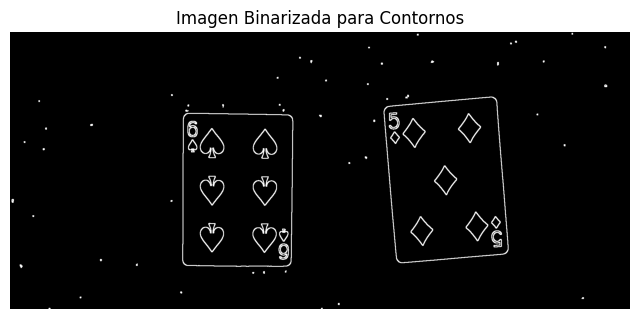

Buscando los contornos de cartas


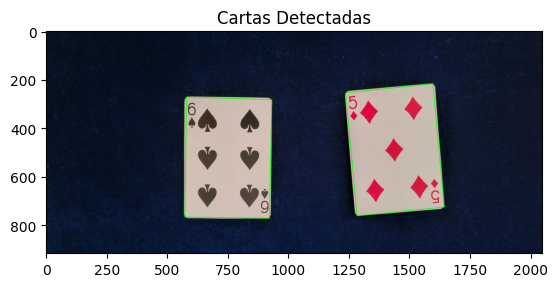

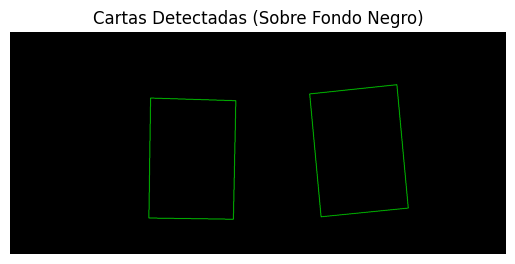

Analizando las cartas


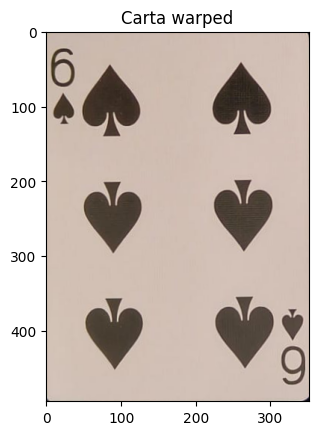

Dimensiones - Alto: 495, Ancho: 352


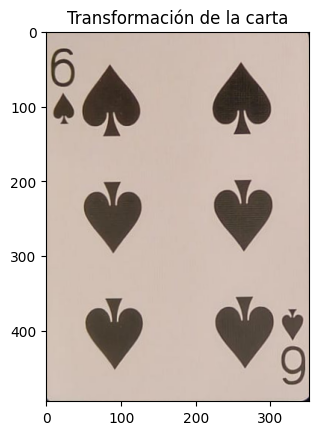

[DEBUG] Dimensiones carta: 352x495 | Ratio: 1.41 | 0.30000000000000004 <= 1.41 <= 1.7
	Resultado:True


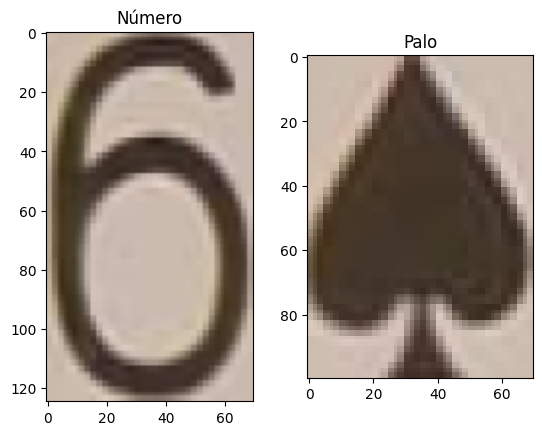

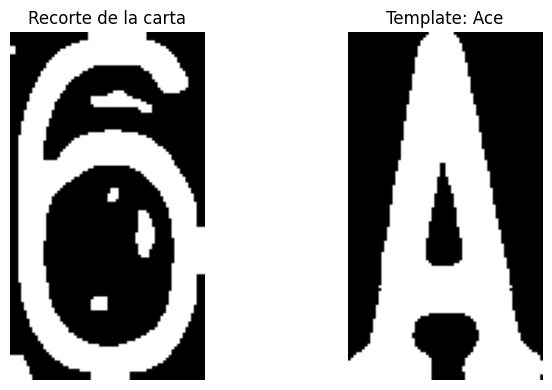

Ace: score = -0.1027


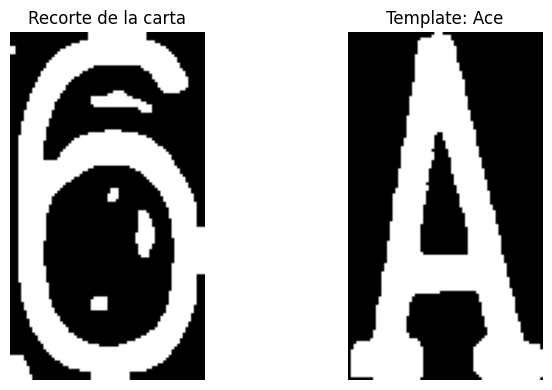

Ace: score = -0.0867


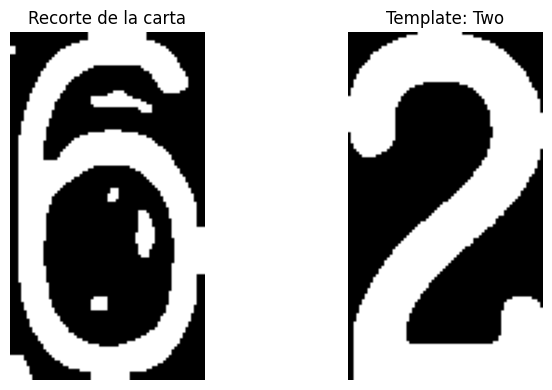

Two: score = 0.0755


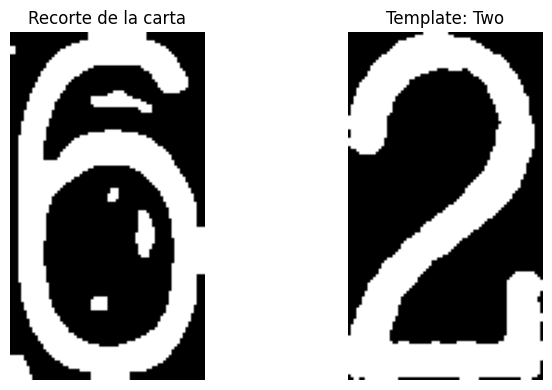

Two: score = 0.1708


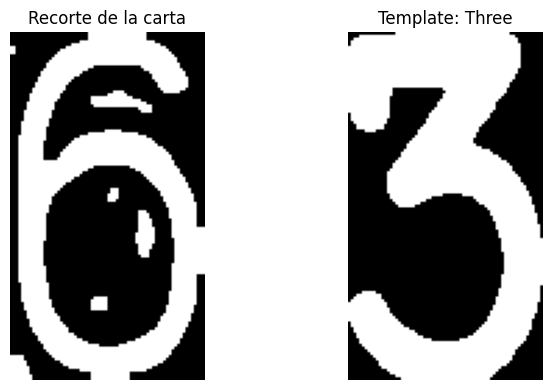

Three: score = 0.3799


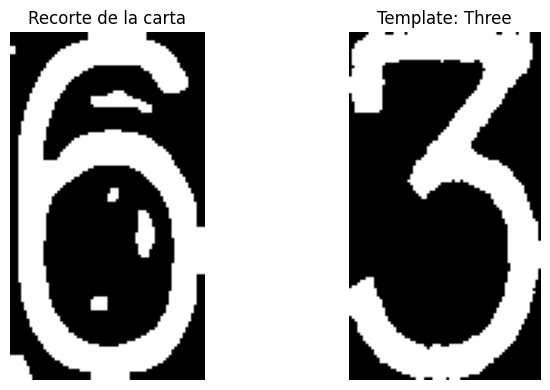

Three: score = 0.3827


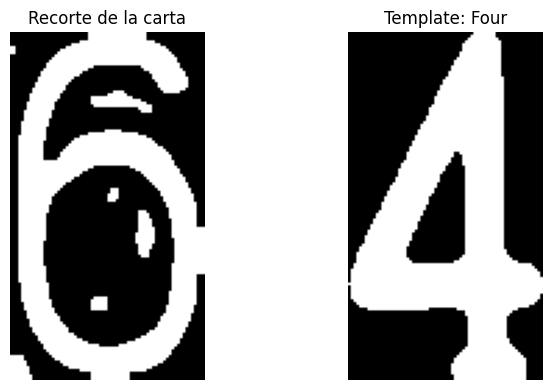

Four: score = 0.0137


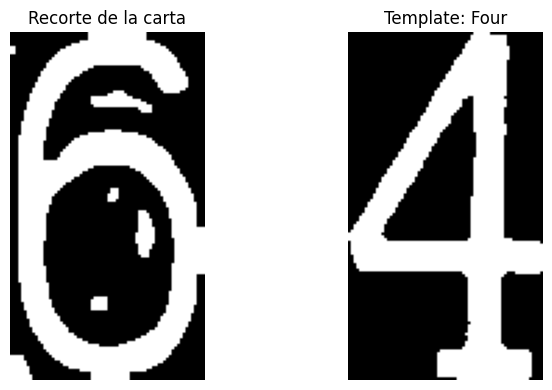

Four: score = 0.0809


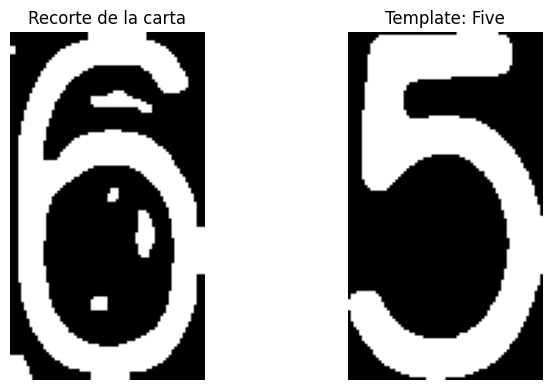

Five: score = 0.5065


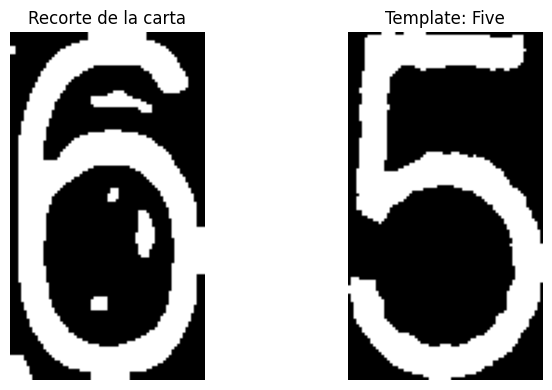

Five: score = 0.5145


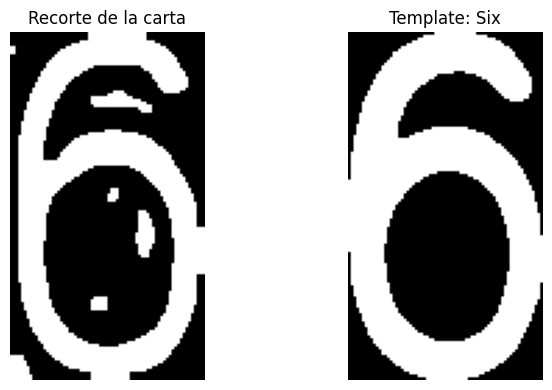

Six: score = 0.7110


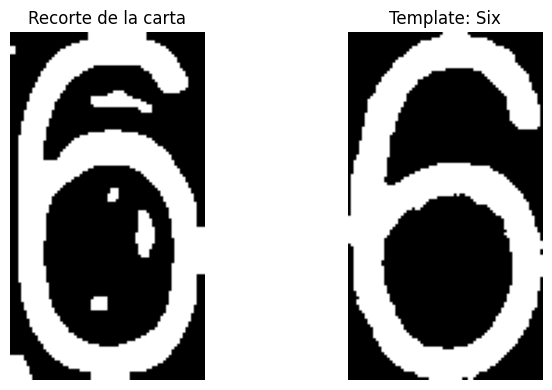

Six: score = 0.5418


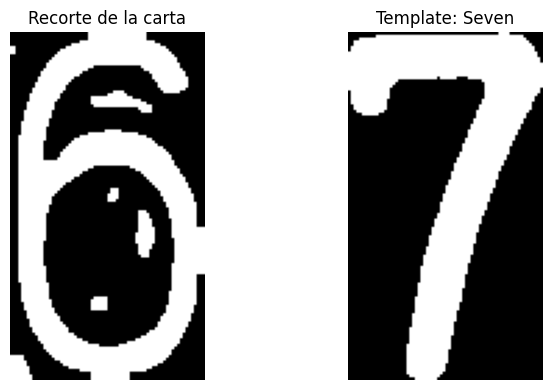

Seven: score = -0.0518


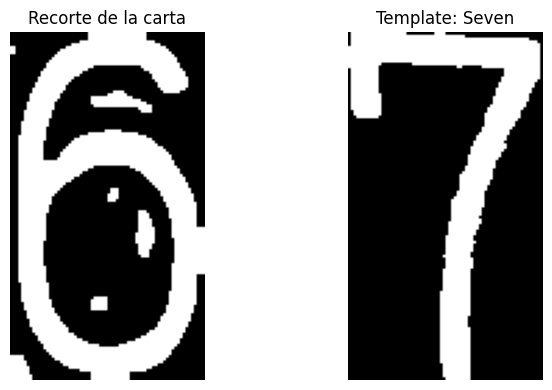

Seven: score = -0.0342


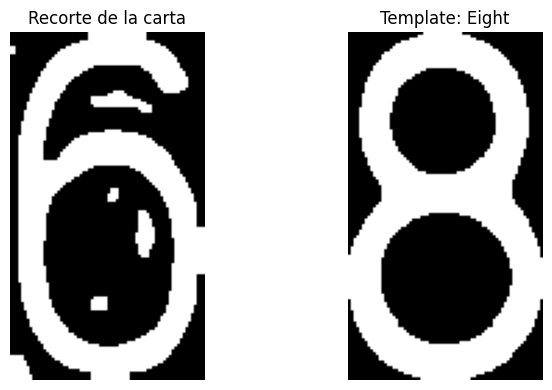

Eight: score = 0.4341


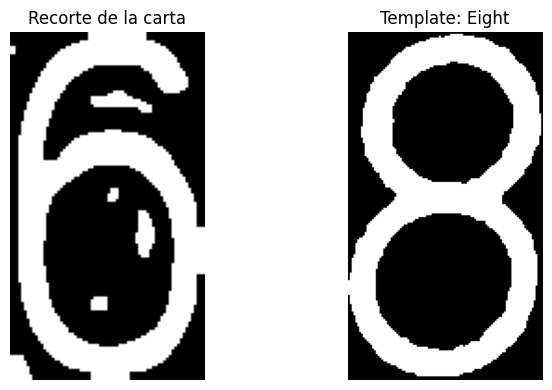

Eight: score = 0.4085


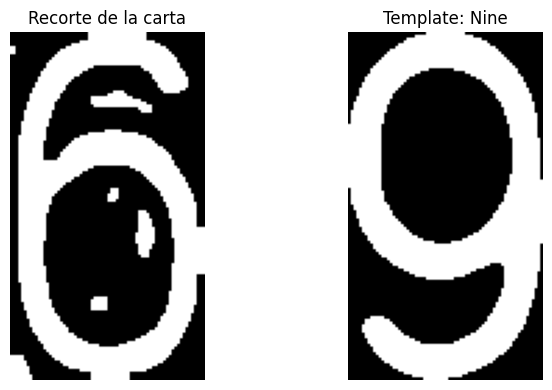

Nine: score = 0.3455


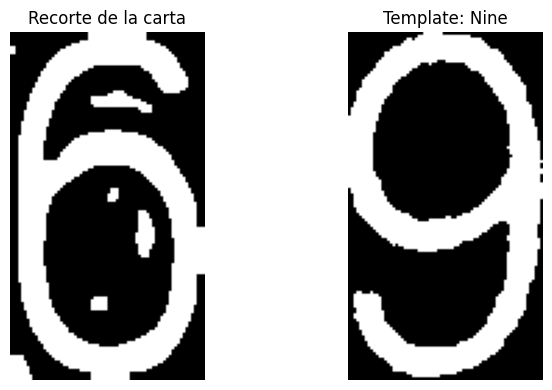

Nine: score = 0.3179


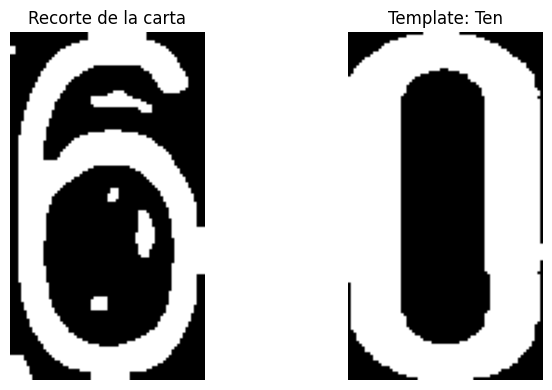

Ten: score = 0.3841


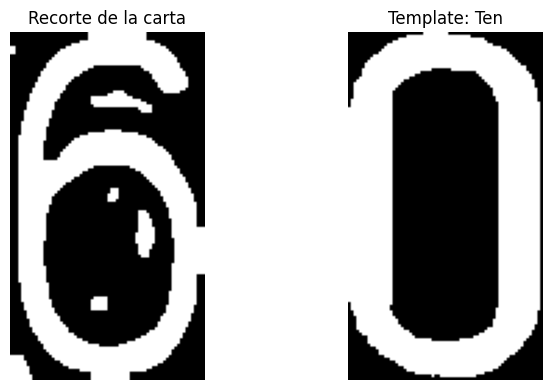

Ten: score = 0.4579


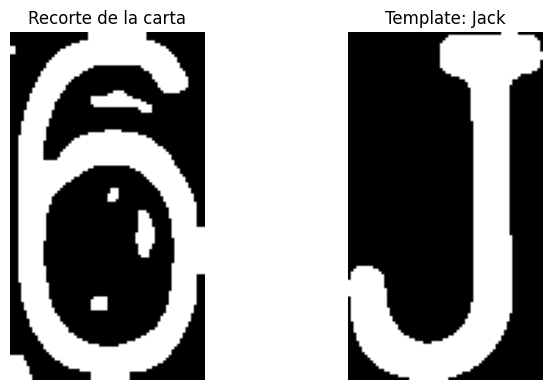

Jack: score = 0.1316


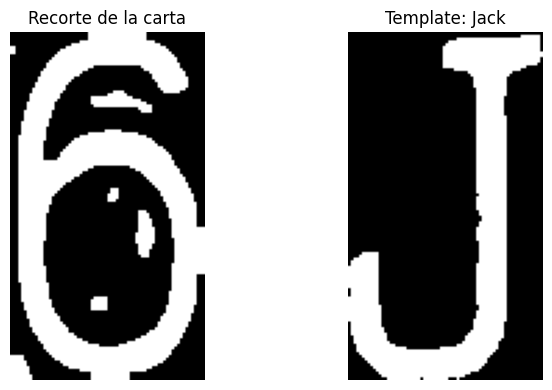

Jack: score = 0.1159


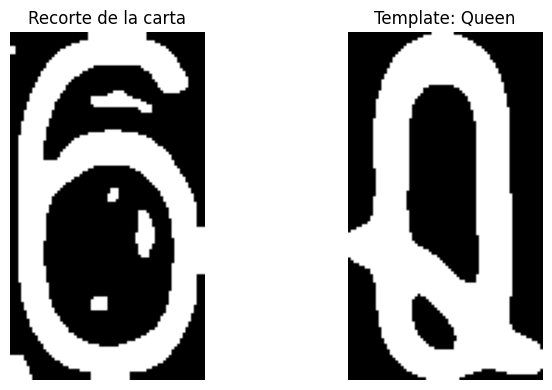

Queen: score = 0.1210


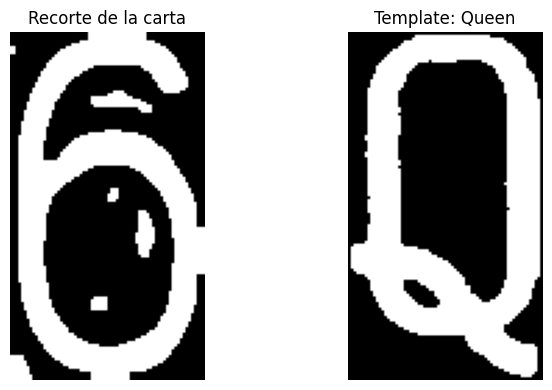

Queen: score = 0.1649


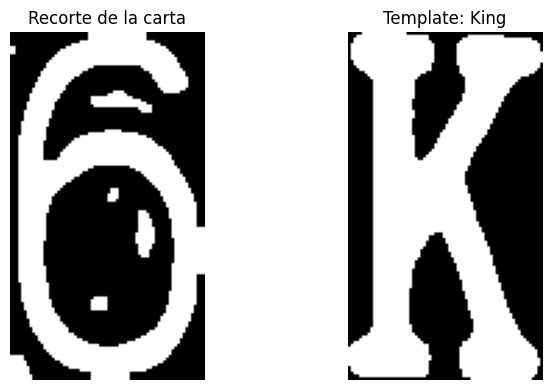

King: score = 0.0208


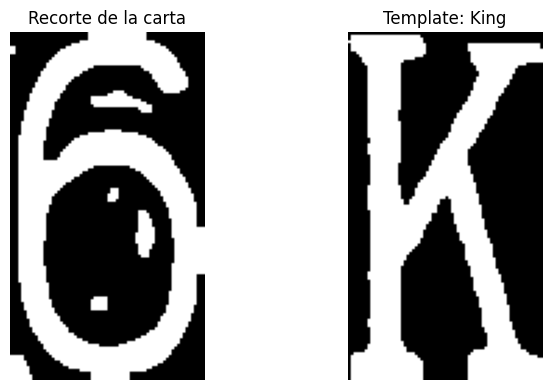

King: score = 0.0565


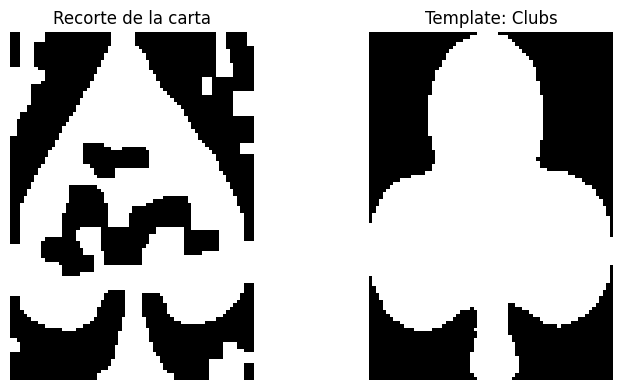

Clubs: score = 0.4982


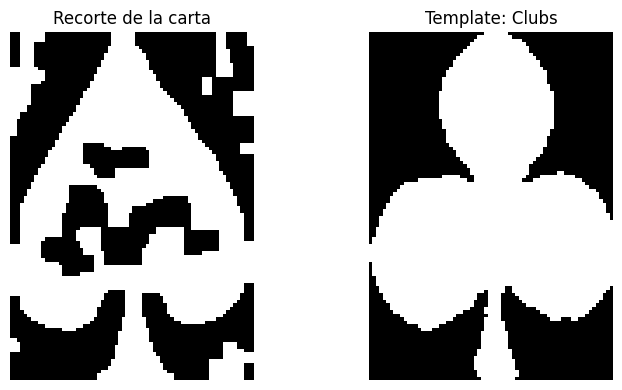

Clubs: score = 0.4686


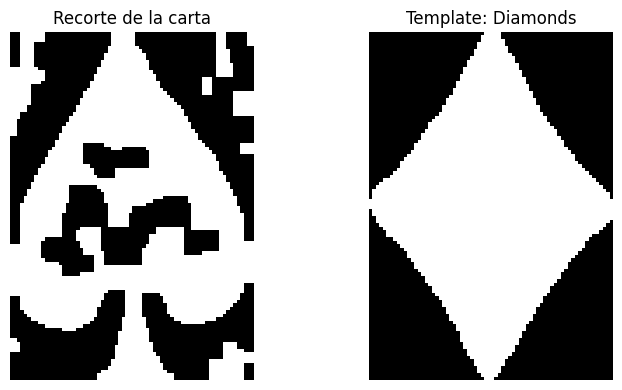

Diamonds: score = 0.3412


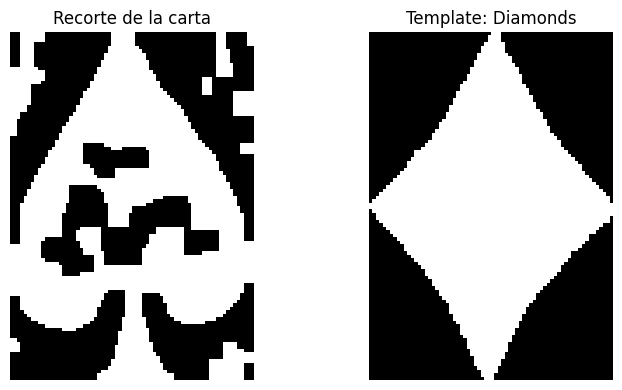

Diamonds: score = 0.3202


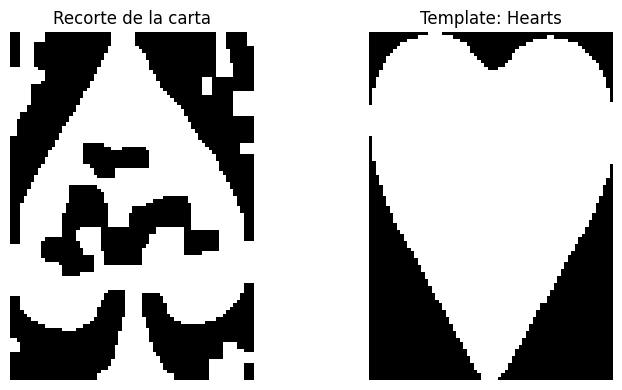

Hearts: score = 0.0579


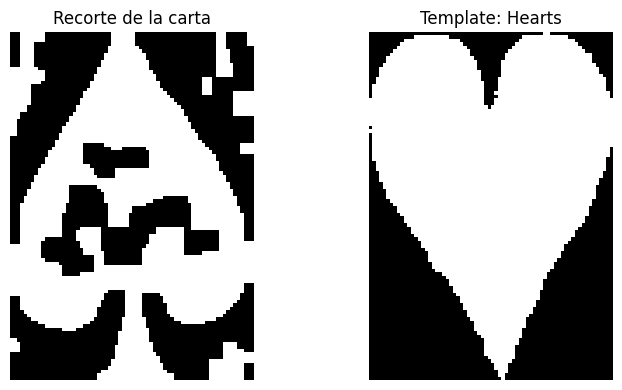

Hearts: score = 0.0232


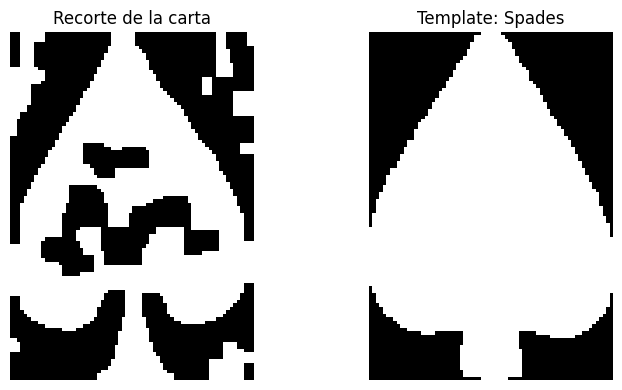

Spades: score = 0.5118


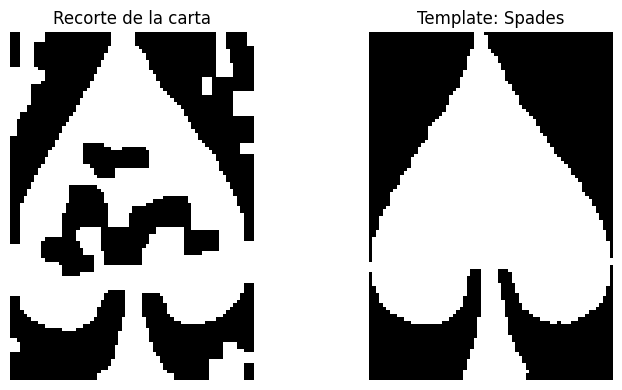

Spades: score = 0.5399
🃏 Card detected: Six of Spades
('Six', 'Spades')


ValueError: too many values to unpack (expected 2)

In [37]:
results = main("Fotos/fotos_multiples/5D6S2.jpg", debug=True)
print(results)
for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

Detectando edges


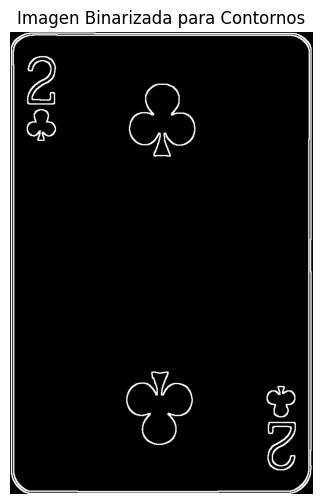

Buscando los contornos de cartas


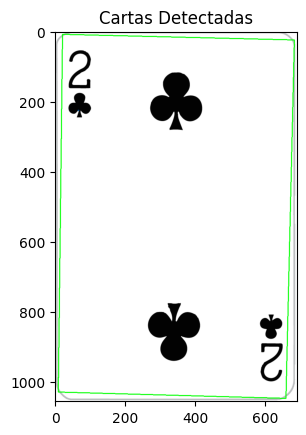

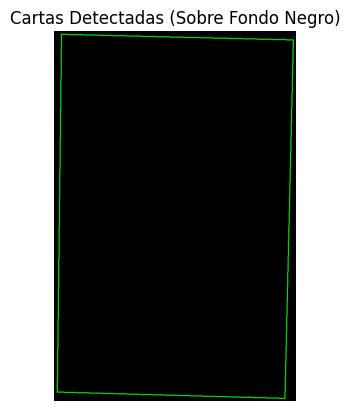

Analizando las cartas


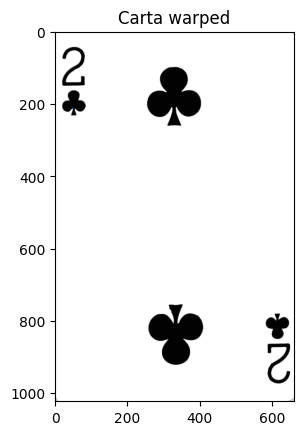

Dimensiones - Alto: 1023, Ancho: 662


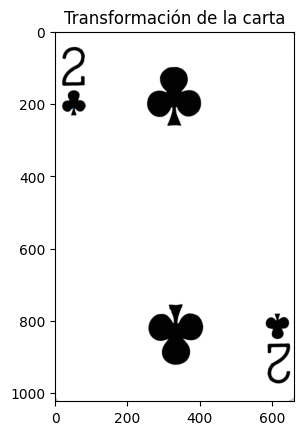

[DEBUG] Dimensiones carta: 662x1023 | Ratio: 1.55 | 0.30000000000000004 <= 1.55 <= 1.7
	Resultado:True


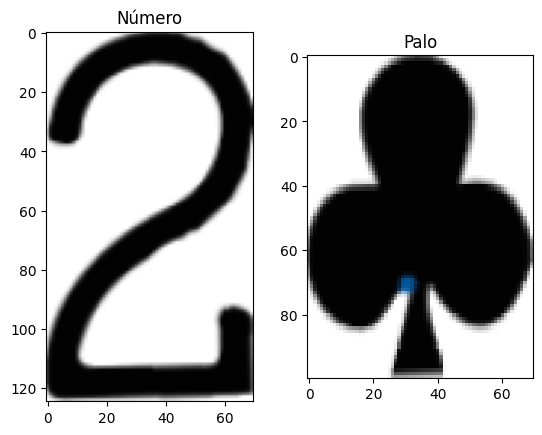

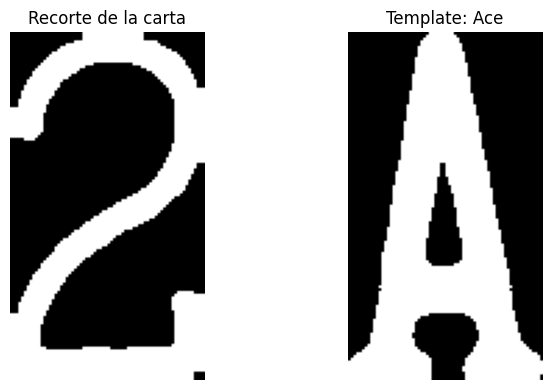

Ace: score = -0.0775


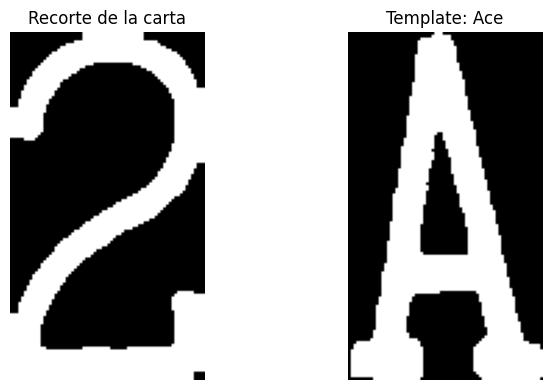

Ace: score = -0.0282


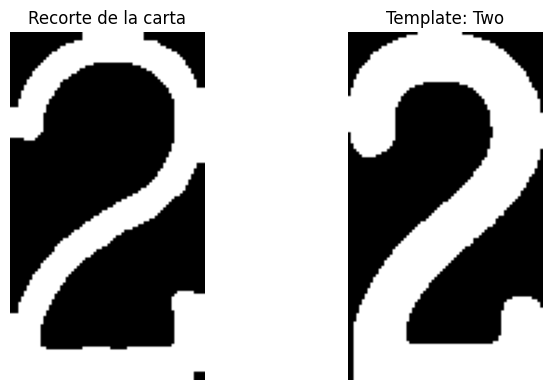

Two: score = 0.6587


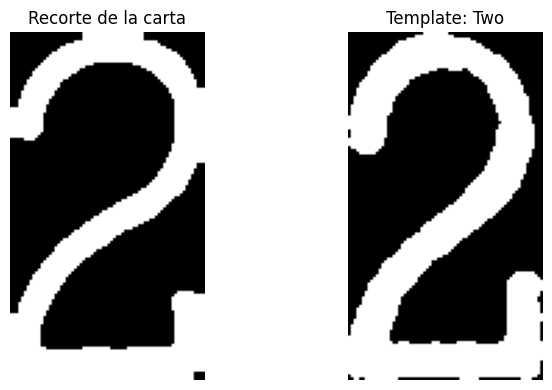

Two: score = 0.6969


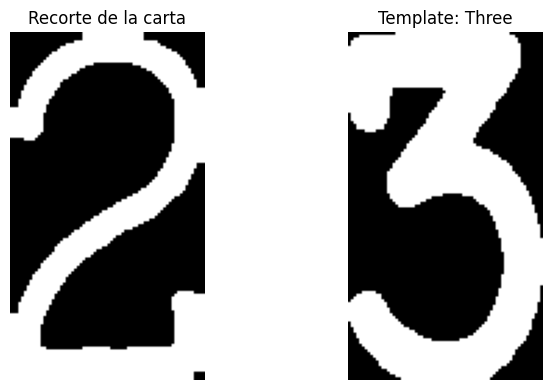

Three: score = 0.0934


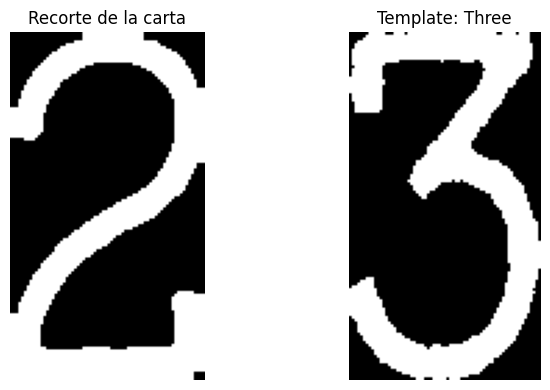

Three: score = 0.1270


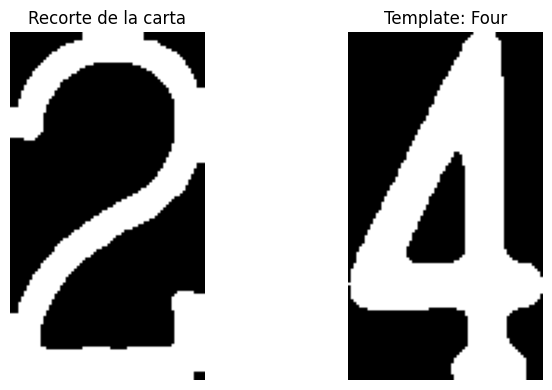

Four: score = -0.2057


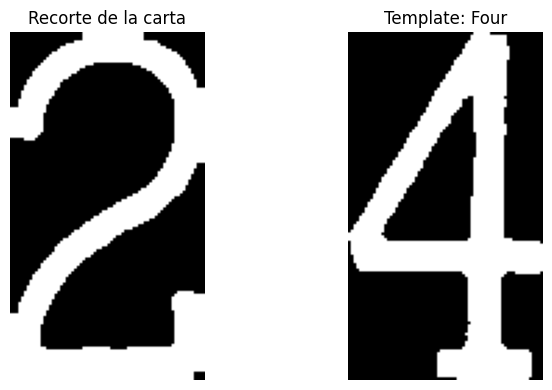

Four: score = -0.1130


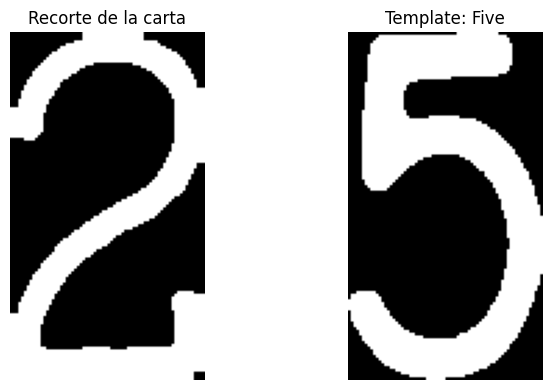

Five: score = 0.0945


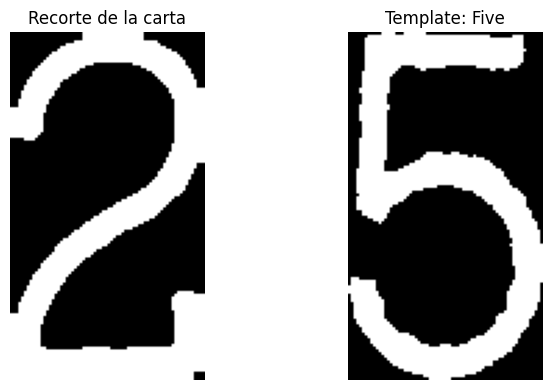

Five: score = 0.1579


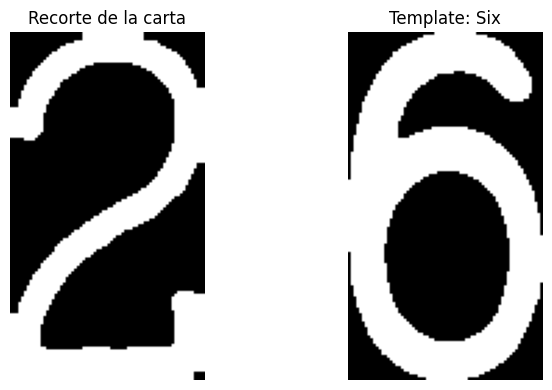

Six: score = 0.0785


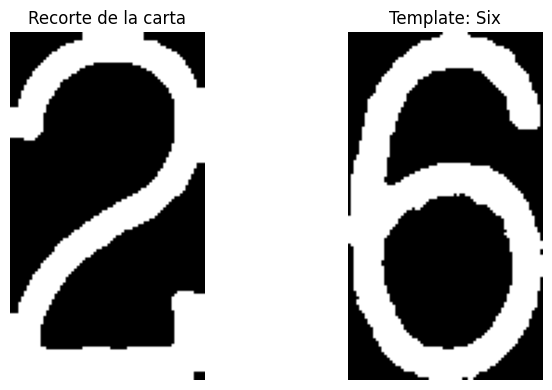

Six: score = 0.1527


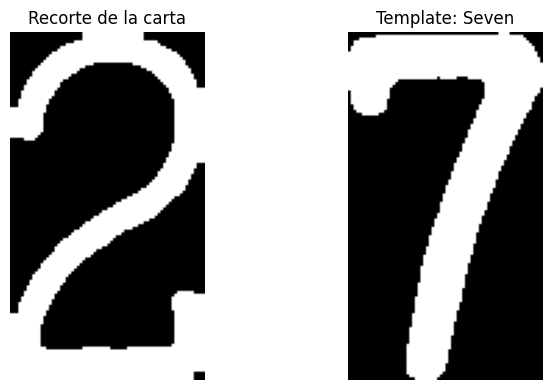

Seven: score = 0.0856


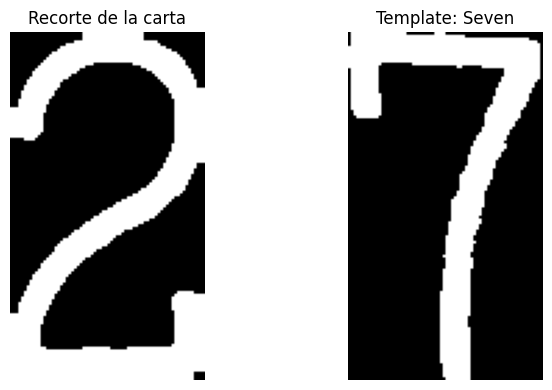

Seven: score = 0.0866


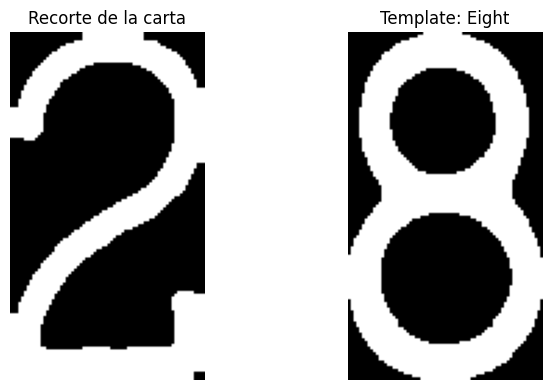

Eight: score = 0.2264


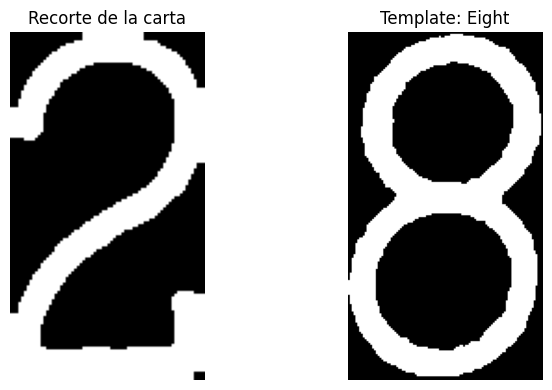

Eight: score = 0.3116


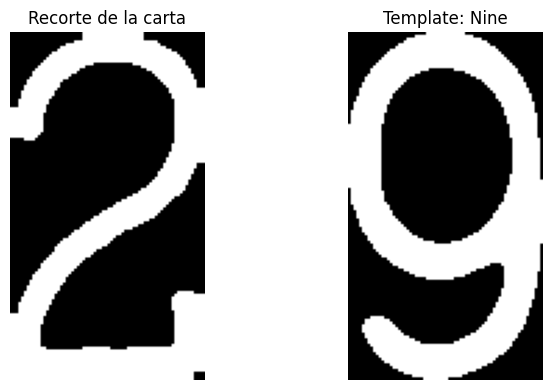

Nine: score = 0.2162


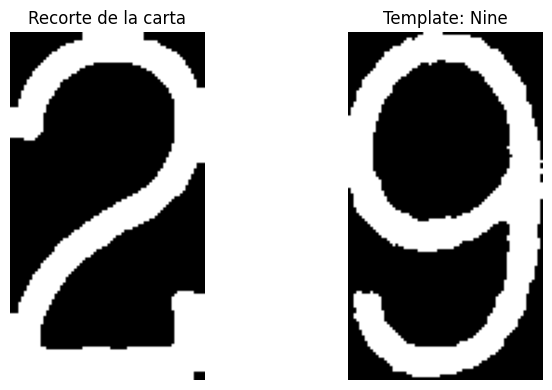

Nine: score = 0.3549


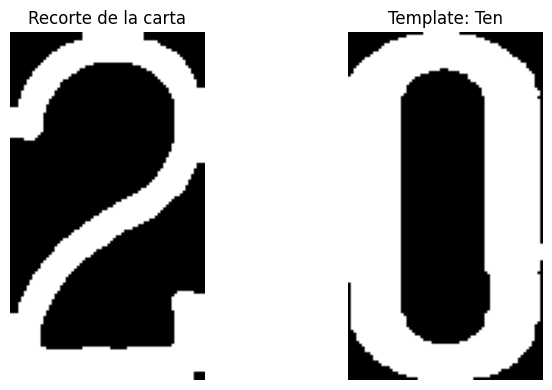

Ten: score = 0.2602


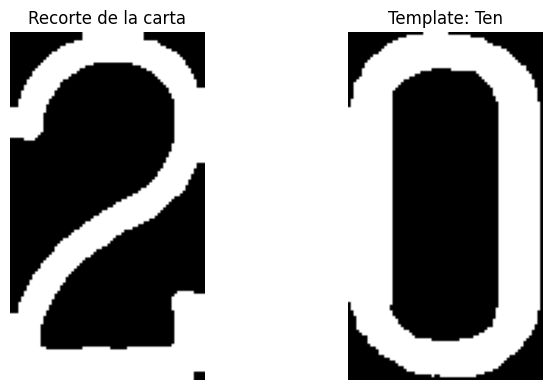

Ten: score = 0.2729


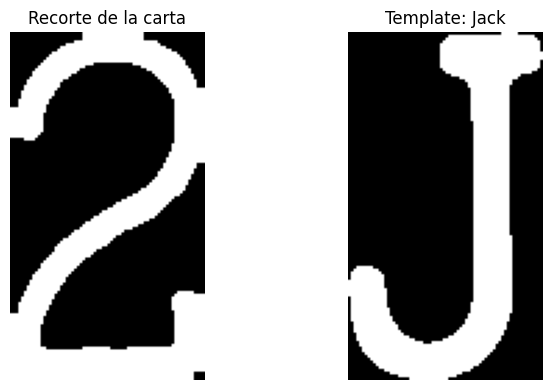

Jack: score = 0.0771


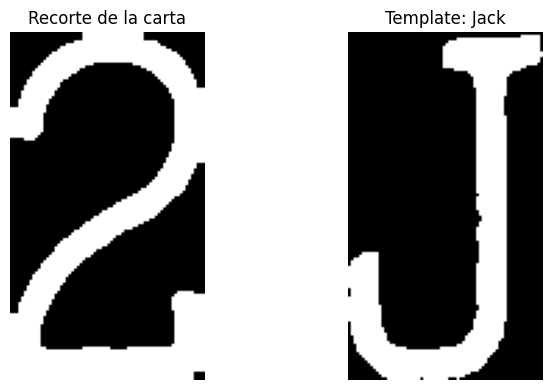

Jack: score = 0.1278


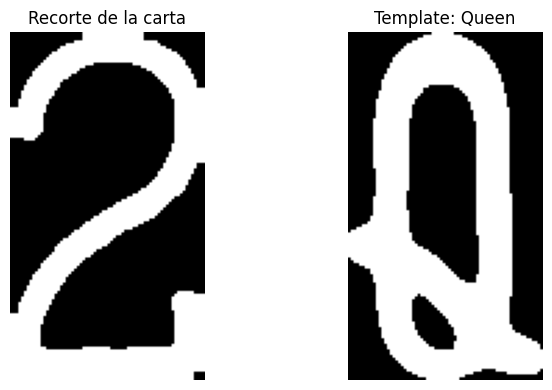

Queen: score = -0.0449


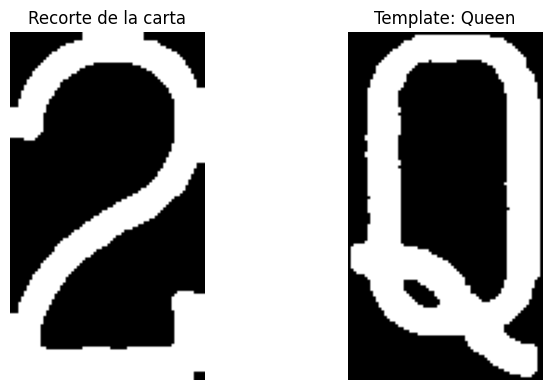

Queen: score = 0.1165


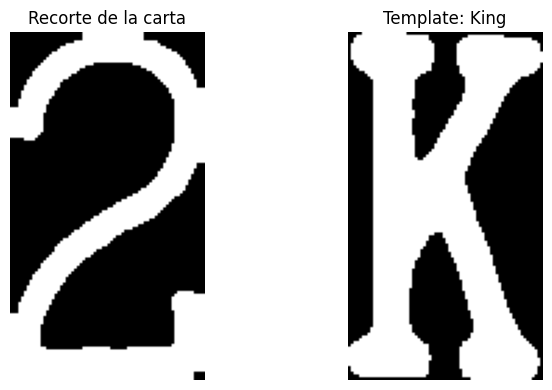

King: score = 0.0411


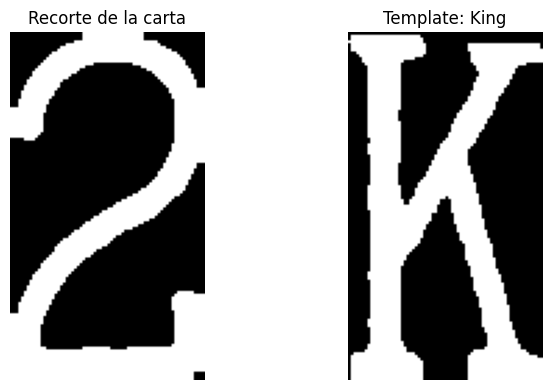

King: score = 0.0671


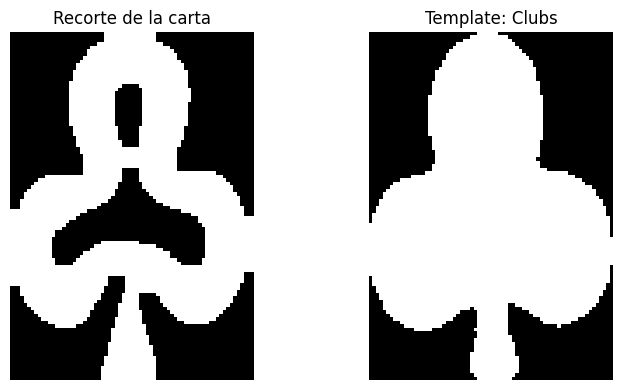

Clubs: score = 0.7129


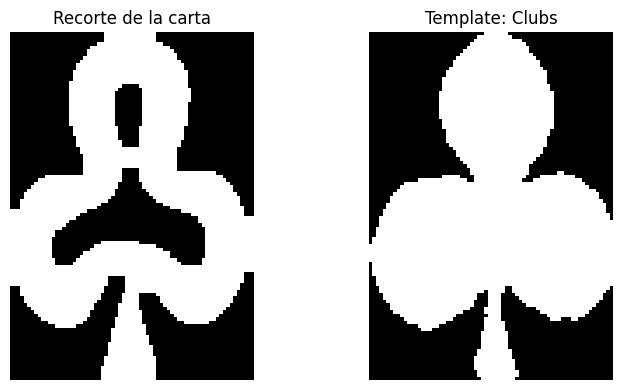

Clubs: score = 0.6391


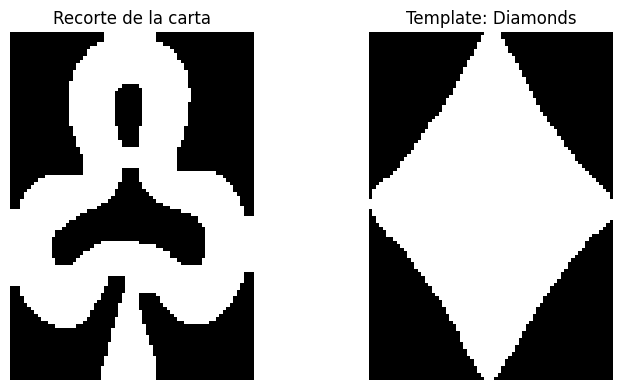

Diamonds: score = 0.3573


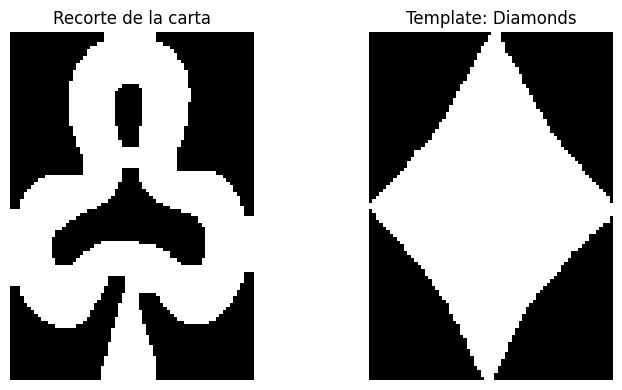

Diamonds: score = 0.3384


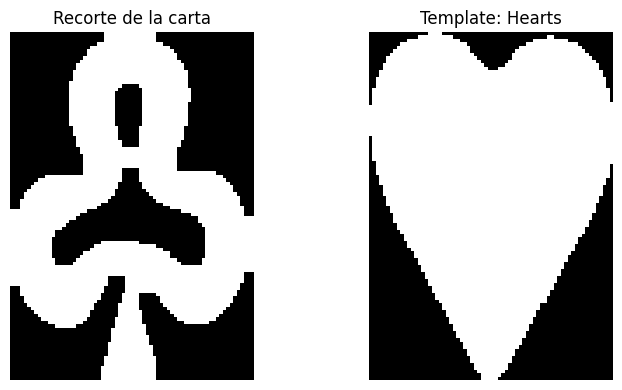

Hearts: score = 0.0764


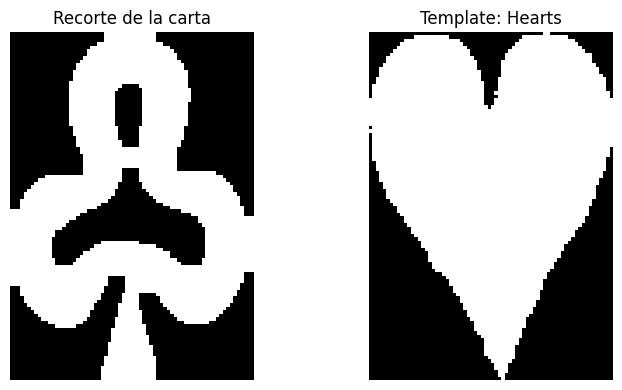

Hearts: score = 0.0277


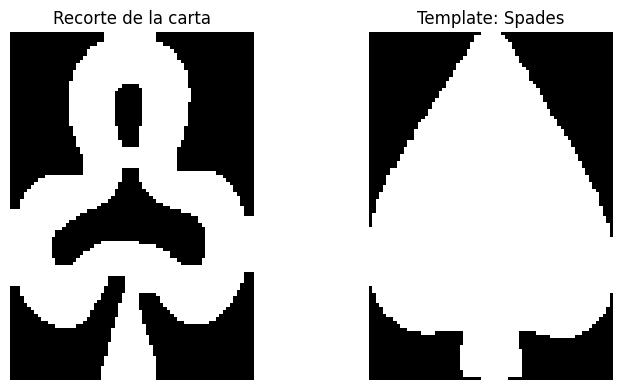

Spades: score = 0.5710


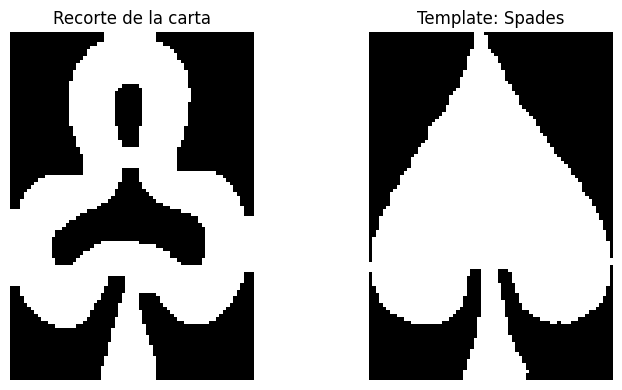

Spades: score = 0.5547
🃏 Card detected: Two of Clubs


ValueError: too many values to unpack (expected 2)

In [38]:
results = main("Fotos/fotos_sencillas/2C.PNG", debug=True)

for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

In [ ]:
main("Fotos/Imagenes/2H27.jpg", debug=True)

In [ ]:
main("Fotos/Imagenes/2S0.jpg", debug=True)

In [ ]:
main("Fotos/Imagenes/AS1.jpg", debug=True)

In [ ]:
main("Fotos/Imagenes/JC0.jpg", debug=True)

## Pruebas de algunas imaganes de todas las cartas

In [41]:
import os
import re
import cv2
import numpy as np

suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

def extraer_datos(nombre):
    match = re.match(r"(\w+)([A-Z])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

# Generar combinaciones: cada carta en 2 posiciones
for number_name, number_symbol in numbers.items():
    for suit_name, suit_symbol in suits.items():
        for i in range(2):
            filename = f"{number_symbol}{suit_symbol}{i}.jpg"
            ruta_completa = os.path.join("Fotos", "Imagenes", filename)

            if not os.path.exists(ruta_completa):
                print(f"⚠️ Archivo no encontrado: {ruta_completa}")
                continue

            print("Archivo:", filename)
            print("-" * 100)

            resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

            number_pred, suit_pred = extraer_datos(filename)
            expected_symbol = number_symbol + suit_symbol

            if not resultados:
                print("❌ No se detectaron cartas")
                succession.append(False)
            else:
                match_encontrado = False
                for number, suit in resultados:
                    if numbers.get(number) == number_symbol and suits.get(suit) == suit_symbol:
                        print(f"✅ Acierto: {number} of {suit}")
                        succession.append(True)
                        match_encontrado = True
                        break

                if not match_encontrado:
                    print(f"❌ Fallo: ninguna coincidencia para {expected_symbol}")
                    succession.append(False)

            print("=" * 100)

# Calcular totales
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

# Calcular porcentajes
porcentaje_aciertos = (aciertos / total) * 100
porcentaje_fallos = (fallos / total) * 100

print(f"\nResumen final:")
print(f"Aciertos: {aciertos} / {total} → {porcentaje_aciertos:.2f}%")
print(f"Fallos: {fallos} / {total} → {porcentaje_fallos:.2f}%")


Archivo: AC0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Clubs
Archivo: AC1.jpg
----------------------------------------------------------------------------------------------------


C:\Users\migue\AppData\Local\Temp\ipykernel_38956\1456415447.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


✅ Acierto: Ace of Clubs
Archivo: AD0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Diamonds
Archivo: AD1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Diamonds
Archivo: AH0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Hearts
Archivo: AH1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo: ninguna coincidencia para AH
Archivo: AS0.jpg
----------------------------------------------------------------------------------------------------
❌ No se detectaron cartas
Archivo: AS1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Spades
Archivo: 2C0.jpg
-----------------------------------------------------------------------------------

KeyboardInterrupt: 

## Prueba de todas las cartas

In [42]:
import os
import re
from tqdm import tqdm  # ✅ Progreso visual
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Diccionarios de conversión
suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

reverse_suits = {v: k for k, v in suits.items()}
reverse_numbers = {v: k for k, v in numbers.items()}

def extraer_datos(nombre):
    match = re.match(r"([A2-9]|10|J|Q|K|A)([CDHS])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

carpeta = os.path.join("Fotos", "Imagenes")
archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(".jpg")]

for filename in tqdm(archivos, desc="Procesando imágenes"):
    ruta_completa = os.path.join(carpeta, filename)

    resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

    # Asumimos que hay al menos una carta detectada
    if not resultados:
        succession.append(False)
        continue

    number, suit = resultados[0]  # ✅ Consideramos solo la primera carta detectada

    number_prediction, suit_prediction = extraer_datos(filename)

    if suit is None or number is None:
        succession.append(False)
    else:
        try:
            match_number = numbers[number]
            match_suit = suits[suit]

            if match_number == number_prediction and match_suit == suit_prediction:
                succession.append(True)
            else:
                succession.append(False)
        except KeyError:
            succession.append(False)

# === RESUMEN FINAL ===
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

porcentaje_aciertos = (aciertos / total) * 100 if total > 0 else 0
porcentaje_fallos = (fallos / total) * 100 if total > 0 else 0

print(f"\nResumen final:")
print(f"Total imágenes: {total}")
print(f"Aciertos: {aciertos} ({porcentaje_aciertos:.2f}%)")
print(f"Fallos: {fallos} ({porcentaje_fallos:.2f}%)")


Procesando imágenes:   0%|▏                                                          | 11/2706 [00:02<10:34,  4.25it/s]C:\Users\migue\AppData\Local\Temp\ipykernel_38956\1456415447.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
Procesando imágenes:   1%|▎                                                          | 15/2706 [00:03<10:59,  4.08it/s]


KeyboardInterrupt: 

## Detección en tiempo real de las cartas

In [43]:
import cv2
import time

def run_realtime(debug=False, draw_predictions=True):
    cap = cv2.VideoCapture(0)  # Usa la cámara por defecto

    if not cap.isOpened():
        print("❌ No se pudo acceder a la cámara.")
        return

    print("🎥 Cámara iniciada. Presiona 'q' para salir.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ No se pudo leer el frame.")
            break

        image = frame.copy()
        original = image.copy()

        edges = preprocess_image(image)
        card_contours = find_card_contours(edges)

        number_templates, suit_templates = load_templates()
        detected_cards = []

        for i, contour in enumerate(card_contours):
            warped = warp_card(image, contour)
            if warped is None:
                continue

            warped = correct_card_orientation(warped, debug)
            if warped is None or not is_valid_card_proportion(warped, debug=debug):
                continue

            number_region, suit_region = extract_number_suit_region(warped, debug=debug)
            if number_region is not None and suit_region is not None:
                number = match_template(number_region, number_templates, debug=debug)
                suit = match_template(suit_region, suit_templates, debug=debug)
                detected_cards.append((contour, number, suit))

        if draw_predictions:
            for contour, number, suit in detected_cards:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = contour[0][0]

                label = f"{number} of {suit}"
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                text_x = cx - text_width // 2
                text_y = cy + text_height // 2

                cv2.putText(original, label, (text_x, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
                cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

        # Mostrar resultado en tiempo real
        cv2.imshow("Cartas Detectadas (Tiempo Real)", original)

        # Presionar 'q' para salir
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
run_realtime(debug=False)


🎥 Cámara iniciada. Presiona 'q' para salir.


C:\Users\migue\AppData\Local\Temp\ipykernel_38956\1456415447.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
